In [1]:
import sys
import os
import subprocess
import tarfile
import shutil

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
from datetime import datetime
from tqdm import tqdm

import boda
from boda.generator.parameters import StraightThroughParameters
from boda.model.mpra_basset import MPRA_Basset
from boda.generator.energy import OverMaxEnergy, StremePenalty
from boda.common import constants, utils

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

from torch.distributions.categorical import Categorical
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm, counts_to_ppm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz'
unpack_artifact(hpo_rec)

model_dir = './artifacts'
model = model_fn(model_dir)
model.cuda()
model.eval()

# activation='ReLU'    
# model = MPRA_Basset(extra_hidden_size = 250,
#                             last_activation=activation)
# checkpoint = torch.load('manual_checkpoint_lasthidden250_ReLU_sneak2_LocusSelect_activity1_4.ckpt')
# model.load_state_dict(checkpoint['state_dict'])
# model.cuda()
# model.eval()

archive unpacked in ./


Loaded model from 20211113_021200 in eval mode


BassetBranched(
  (pad1): ConstantPad1d(padding=(9, 9), value=0.0)
  (conv1): Conv1dNorm(
    (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
    (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad2): ConstantPad1d(padding=(5, 5), value=0.0)
  (conv2): Conv1dNorm(
    (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad3): ConstantPad1d(padding=(3, 3), value=0.0)
  (conv3): Conv1dNorm(
    (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
  (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (maxpool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): LinearNorm(
    (linear): Linear(in

In [3]:
class IntegratedSampledGradients(nn.Module):
    def __init__(self,
                 target_distributions,
                 predictor,
                 baseline=None,
                 num_samples=1,
                 batch_dim=0,
                 token_dim=-2,
                 cat_dim=-1):
        super().__init__()
        self.predictor = predictor  
        self.baseline = baseline
        self.num_samples = num_samples
        self.batch_dim = batch_dim
        self.token_dim = token_dim
        self.cat_dim = cat_dim
        
        self.register_buffer('target_distributions', target_distributions)
        self.target_distributions.requires_grad_()       
        self.grad = torch.autograd.grad
        
        self.num_classes = self.target_distributions.shape[self.token_dim]
        self.batch_size = self.target_distributions.shape[self.batch_dim]
        self.n_dims = len(self.target_distributions.shape)
        self.repeater = [ 1 for i in range(self.n_dims) ]

        if self.baseline == None:
            base_distribution = 0.25 * torch.ones_like(self.target_distributions)
            self.register_buffer('base_distribution', base_distribution)
        else:
            self.register_buffer('base_distribution', baseline.view(self.target_distributions.shape))
        self.base_distribution.requires_grad_()
        
    def rebatch(self, input):
        return input.unflatten(0, (self.num_samples, self.batch_size)).mean(dim=0)

    def get_samples(self, distribution):
        nucleotide_probs = Categorical(torch.transpose(distribution, self.token_dim, self.cat_dim))
        sampled_idxs = nucleotide_probs.sample((self.num_samples, ))
        sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=self.num_classes)        
        sampled_nucleotides = torch.transpose(sampled_nucleotides_T, self.token_dim, self.cat_dim)
        multi_distribution = distribution.repeat(self.num_samples, *self.repeater)
        sampled_nucleotides = sampled_nucleotides - multi_distribution.detach() + multi_distribution 
        return sampled_nucleotides

    def get_gradients(self, distributions):
        samples = self.get_samples(distributions).flatten(0,1)
        predictions = self.rebatch(self.predictor(samples))
        gradients = torch.autograd.grad(predictions.sum(), inputs=distributions, retain_graph=True)[0]
        return gradients

    def get_point_distribution(self, k):
        return self.base_distribution + k * (self.target_distributions - self.base_distribution)

    def integrate_gradients(self, num_steps=10, num_samples=20):
        self.num_samples = num_samples
        line_gradients = []
        for i in tqdm(range(num_steps + 1)):
            slope = i / num_steps
            point_distribution = self.get_point_distribution(slope)
            point_gradients = self.get_gradients(point_distribution)
            line_gradients.append(point_gradients)
        return torch.stack(line_gradients).mean(dim=0)
    
    def get_salient_maps(self, num_steps=10, num_samples=20):
        self.num_samples = num_samples
        gradients = self.integrate_gradients(num_steps).to(self.target_distributions.device)        
        salient_maps =  gradients * self.target_distributions
        return salient_maps.detach()

In [4]:
class mpra_predictor(nn.Module):
    def __init__(self,
                 model,
                 pred_idx=0,
                 ini_in_len=200,
                 model_in_len=600,
                 cat_axis=-1):
        super().__init__()
        self.model = model
        self.pred_idx = pred_idx
        self.ini_in_len = ini_in_len 
        self.model_in_len = model_in_len
        self.cat_axis = cat_axis       
        
        try: self.model.eval()
        except: pass
        
        self.register_flanks()
    
    def forward(self, x):
        pieces = [self.left_flank.repeat(x.shape[0], 1, 1), x, self.right_flank.repeat(x.shape[0], 1, 1)]
        in_tensor = torch.cat( pieces, axis=self.cat_axis)
        out_tensor = self.model(in_tensor)[:, self.pred_idx]
        return out_tensor
    
    def register_flanks(self):
        missing_len = self.model_in_len - self.ini_in_len
        left_idx = - missing_len//2 + missing_len%2
        right_idx = missing_len//2 + missing_len%2
        left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[left_idx:]).unsqueeze(0)
        right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:right_idx]).unsqueeze(0)         
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank) 
        
class mpra_predictor_no_flanks(nn.Module):
    def __init__(self,
                 model,
                 pred_idx=0):
        super().__init__()
        self.model = model
        self.pred_idx = pred_idx       
        
        try: self.model.eval()
        except: pass
            
    def forward(self, x):
        return self.model(x)[:, self.pred_idx]     

## Exploring scoring longer sequences

In [8]:
test_str = 'CTGGATAATCTACAAAATAGACAAATATCTCCAAGTTTACAGGTTTATTTAGGAACTGGTATAATGAGGGGAGCCTCTGTCTGCCTTTGATGCCTACCTATAGGCAGTGTTTAAGTATTAGACATTTTAGAGCATCATAATTTTCTCAAGTGAAAATGATAATAAGAGGTTAACTTTTTTAAAAAATGAGGAAAACATGTTCTTGACCTCTGAAAATTGTTGTTGCAAATAAGCTGTACTCTCCAGTTTCCAGGGACTATCTCTT'

In [7]:
window_len = 200
predictor = mpra_predictor(model=model, ini_in_len=window_len)
predictor.cuda()

all_preds = []
for i in range(len(test_str)-200):
    test_tensor = utils.dna2tensor(test_str[i:i+200]).unsqueeze(0).view(1,4,-1)
    predictions = predictor(test_tensor.cuda()).detach().cpu().numpy()
    all_preds.append(predictions)
    
all_preds = np.stack(all_preds)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [8]:
all_preds.mean(axis=0)

array([0.03947089], dtype=float32)

In [9]:
test_tensor = utils.dna2tensor(test_str).unsqueeze(0).view(1,4,-1)
window_len = test_tensor.shape[-1]

predictor = mpra_predictor(model=model, ini_in_len=window_len)
predictor.cuda()
single_prediction = predictor(test_tensor.cuda()).detach().cpu().numpy()
print(single_prediction)

[0.20250252]


In [10]:
window_size = 200
test_distributions = torch.stack([utils.dna2tensor(test_str[i:i+window_size]) for i in range(len(test_str)-window_size)])

In [11]:
predictor = mpra_predictor(model=model, ini_in_len=window_size)
predictor.cuda()
attributer = IntegratedSampledGradients(test_distributions, predictor, num_samples=20)
attributer.cuda()

IntegratedSampledGradients(
  (predictor): mpra_predictor(
    (model): BassetBranched(
      (pad1): ConstantPad1d(padding=(9, 9), value=0.0)
      (conv1): Conv1dNorm(
        (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
        (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (pad2): ConstantPad1d(padding=(5, 5), value=0.0)
      (conv2): Conv1dNorm(
        (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
        (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (pad3): ConstantPad1d(padding=(3, 3), value=0.0)
      (conv3): Conv1dNorm(
        (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
        (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
      (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False

In [12]:
%%time
salient_maps = attributer.get_salient_maps(num_steps=100, num_samples=20).cpu()

100%|██████████| 101/101 [00:13<00:00,  7.72it/s]

CPU times: user 13.1 s, sys: 106 ms, total: 13.2 s
Wall time: 13.1 s


In [13]:
%%time
gradients = attributer.integrate_gradients(num_steps=100, num_samples=20).cpu()

100%|██████████| 101/101 [00:13<00:00,  7.75it/s]

CPU times: user 13 s, sys: 46.2 ms, total: 13.1 s
Wall time: 13 s


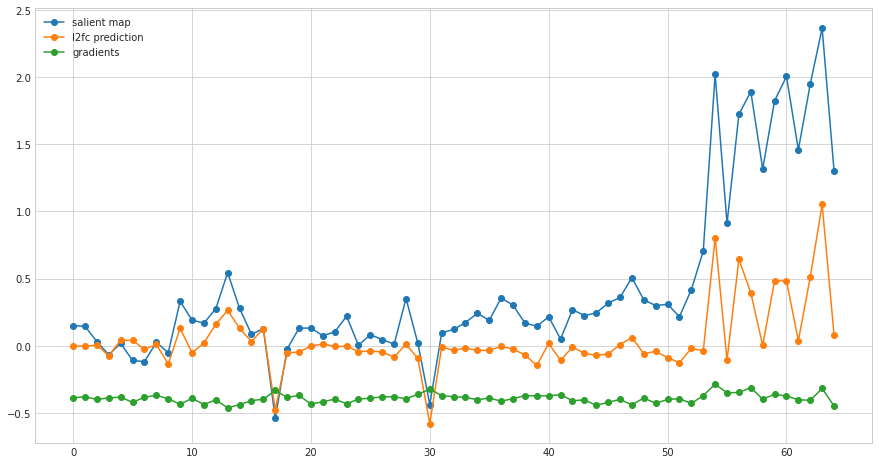

In [14]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(15,8))
    plt.plot(salient_maps.sum(dim=-1).sum(dim=-1), label='salient map', linestyle='-', marker='o')    
    plt.plot(all_preds, label='l2fc prediction', linestyle='-', marker='o')
    plt.plot(gradients.sum(dim=-1).sum(dim=-1), label='gradients', linestyle='-', marker='o')
    plt.legend()
    plt.show()

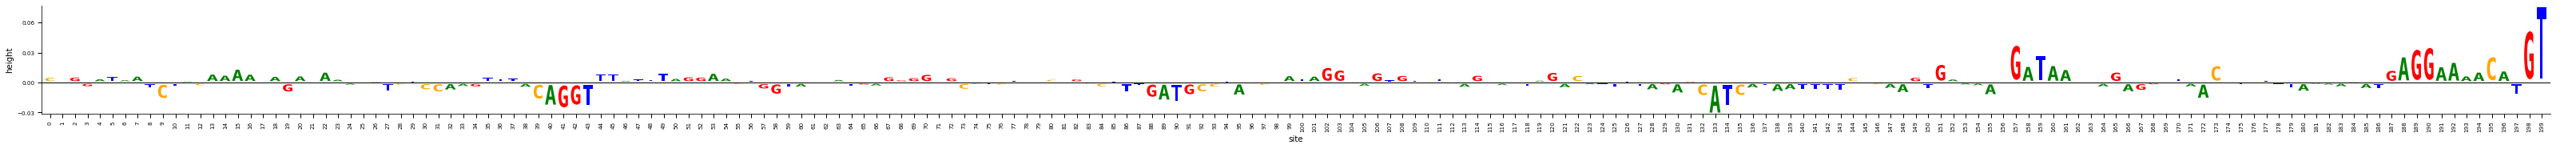

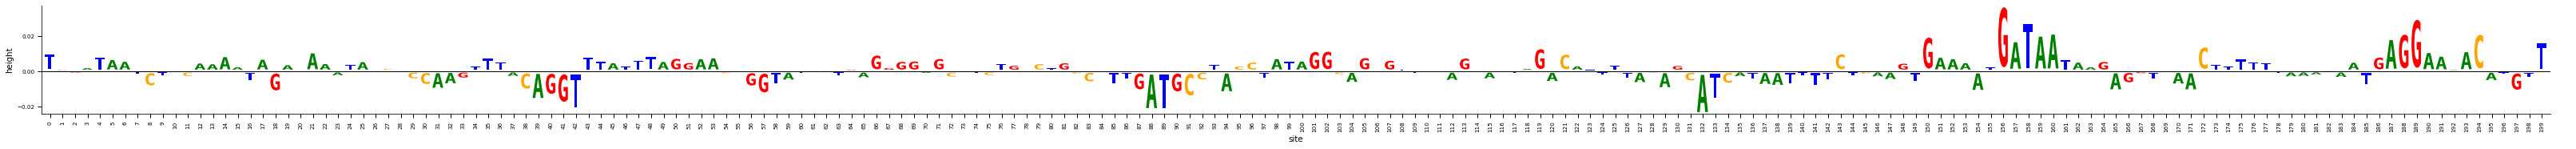

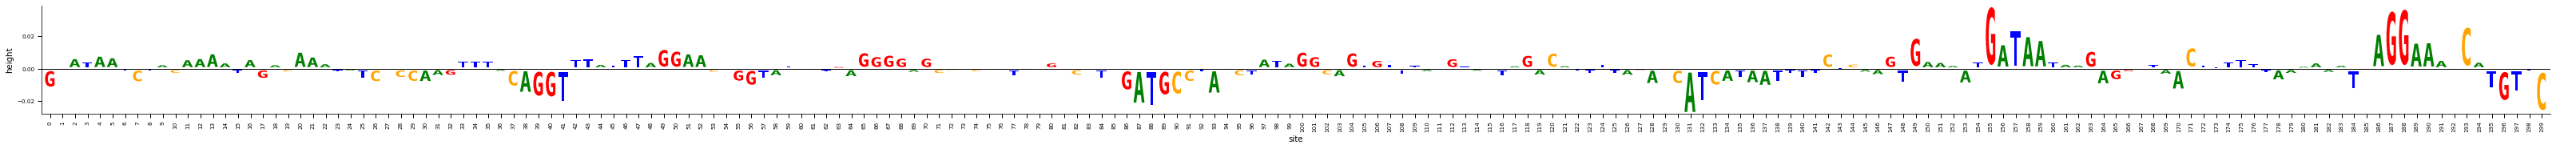

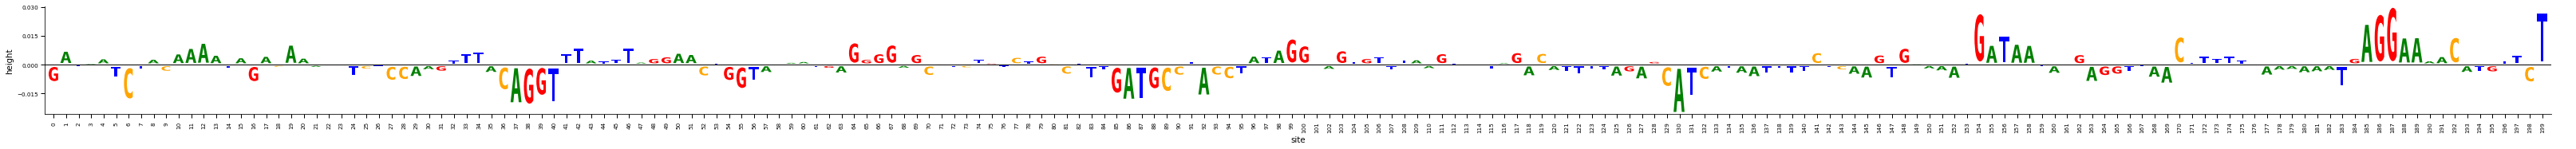

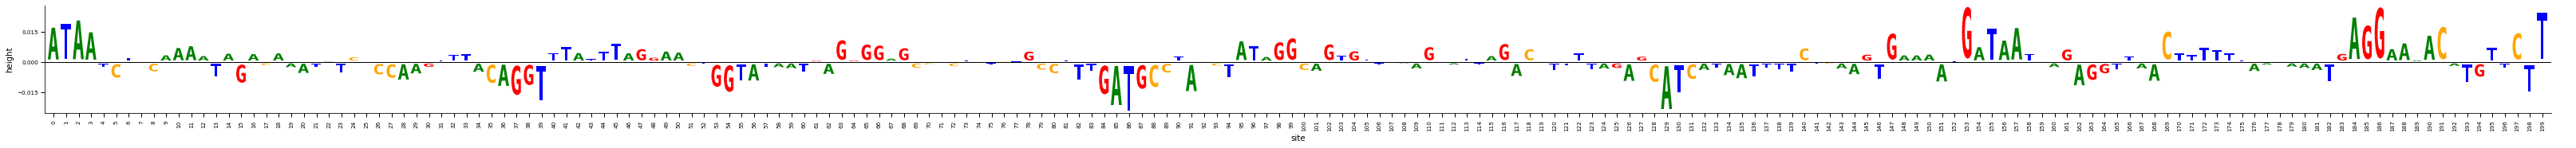

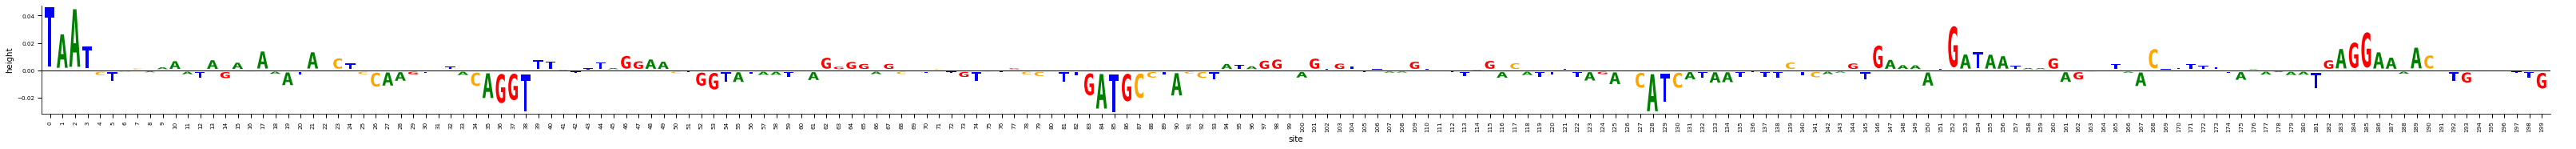

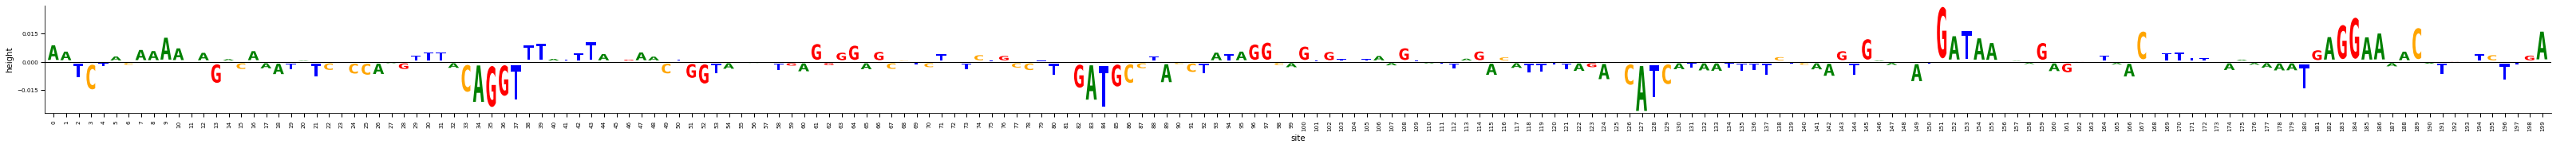

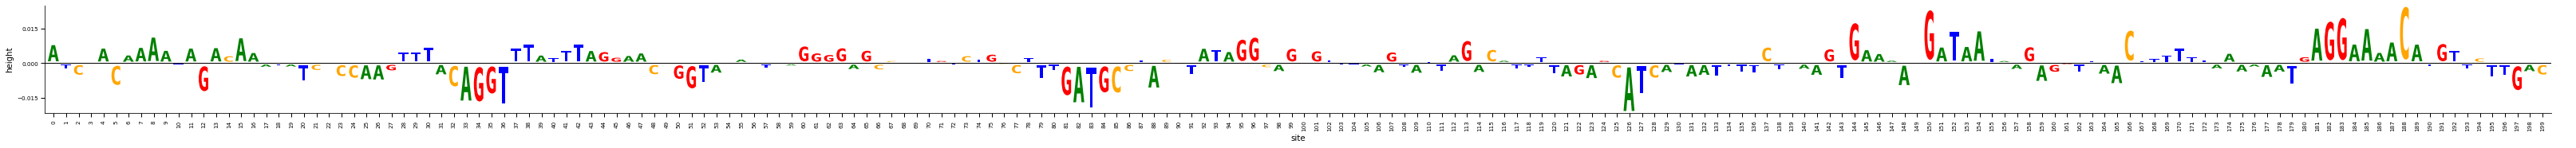

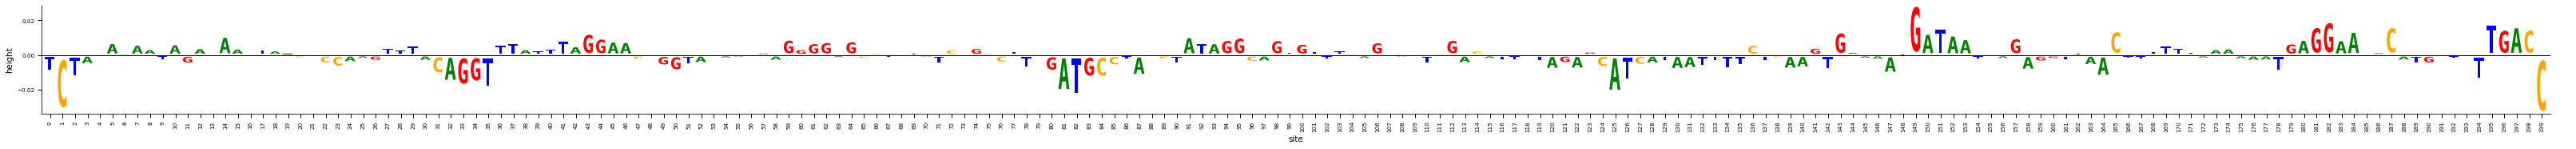

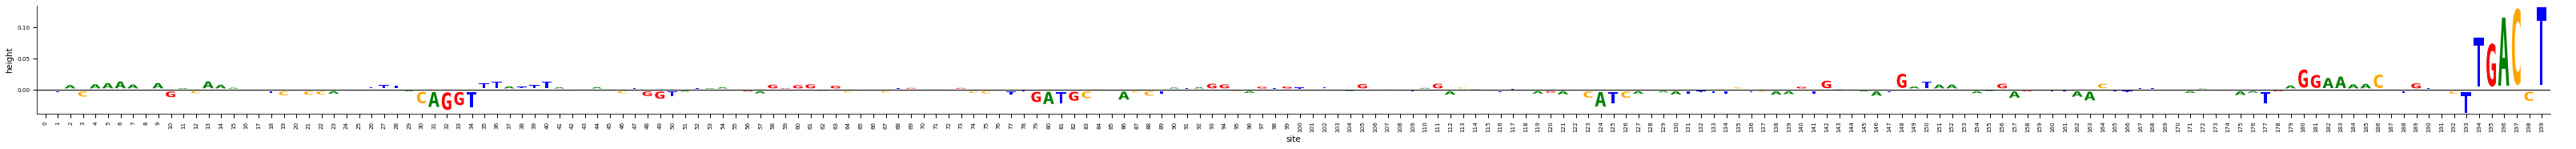

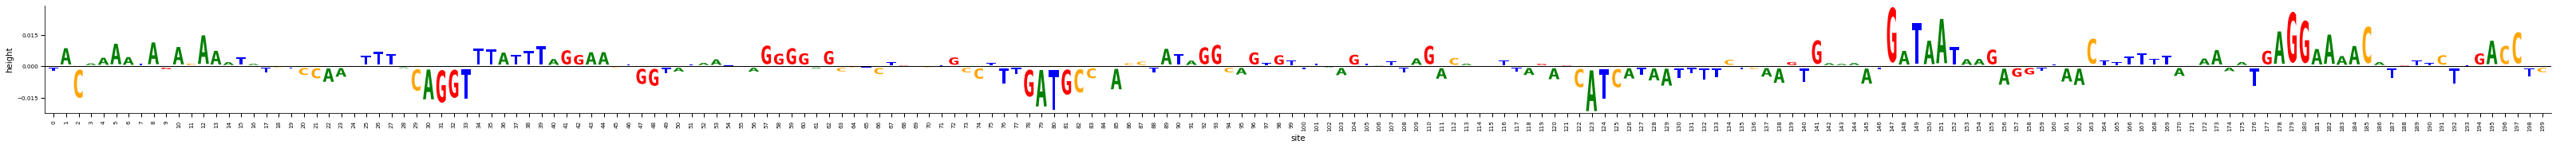

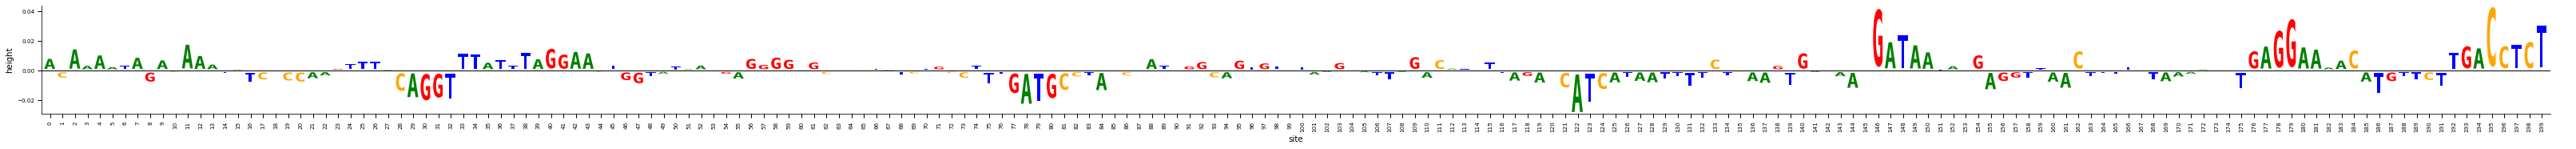

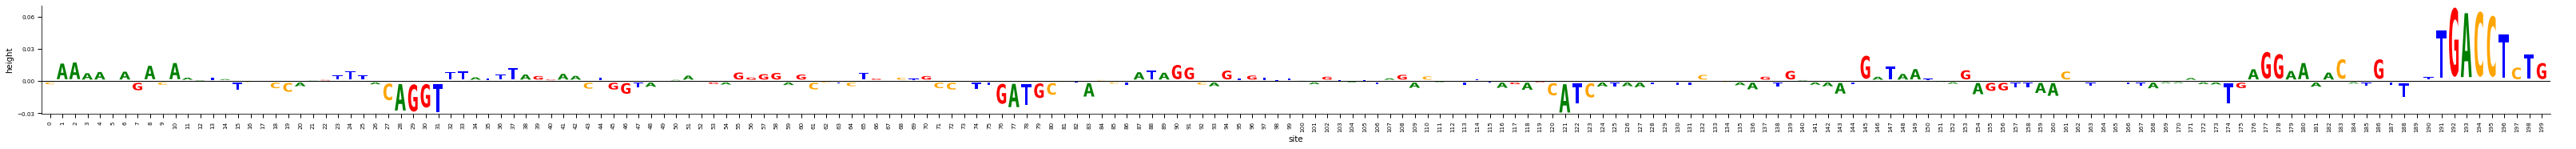

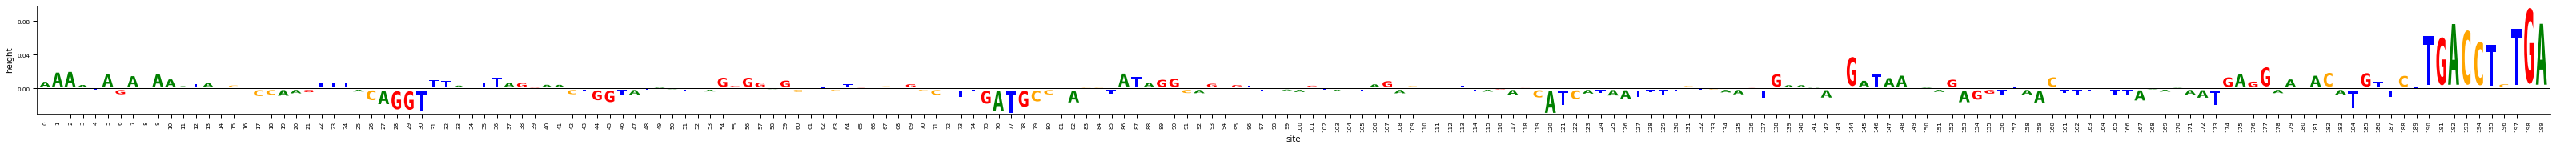

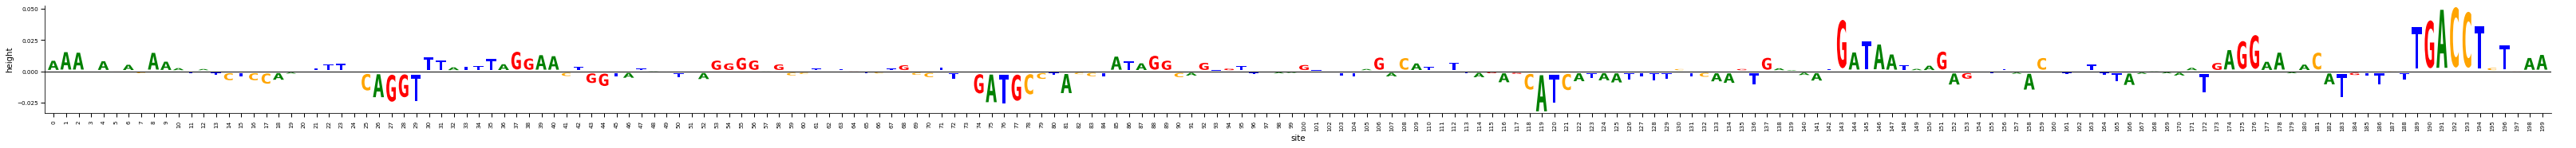

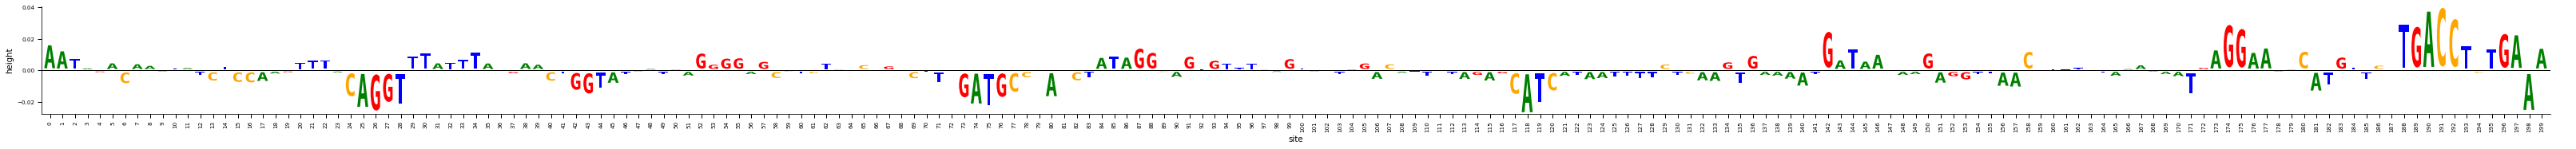

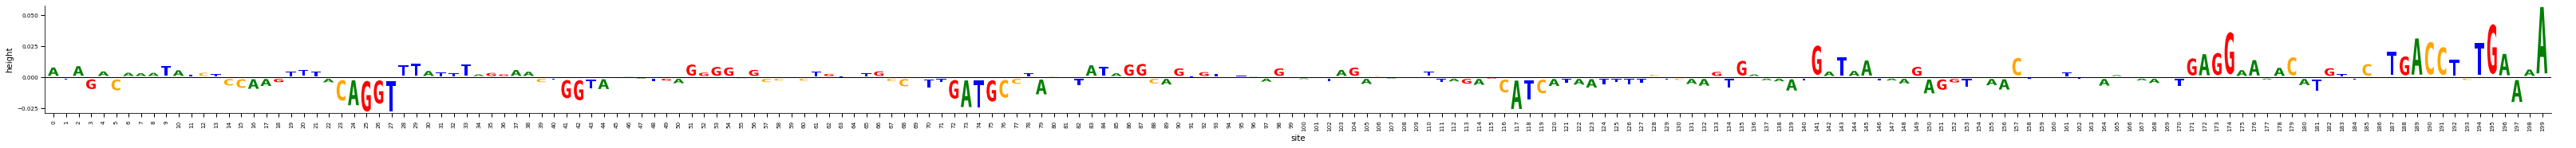

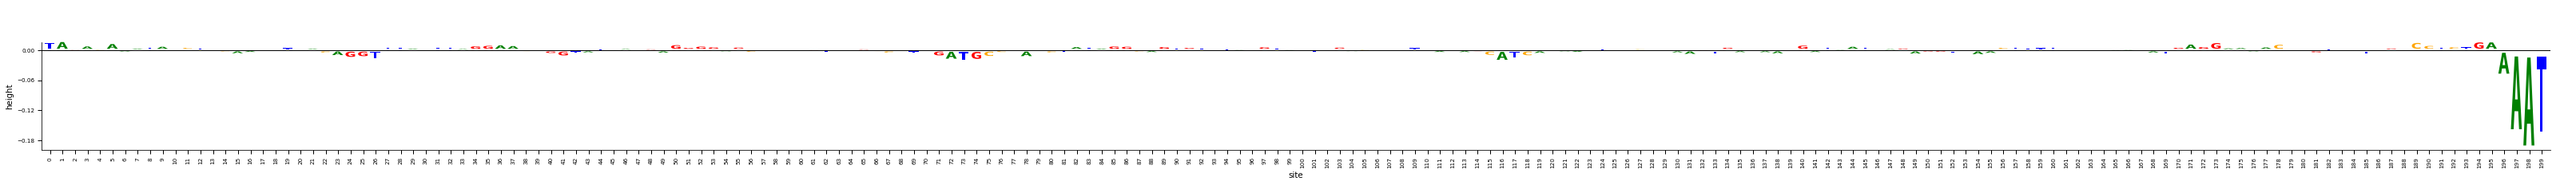

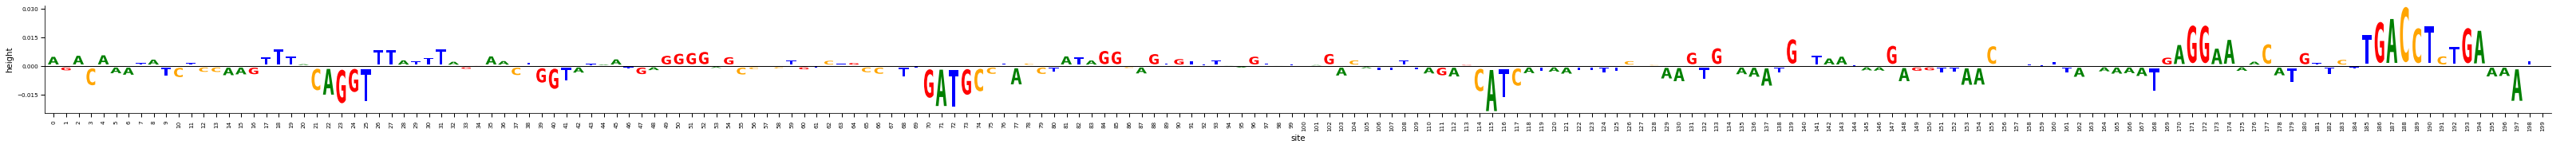

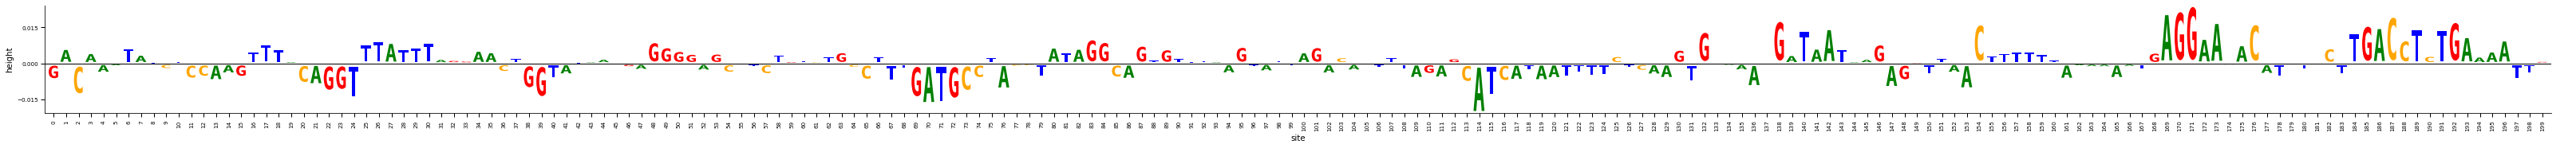

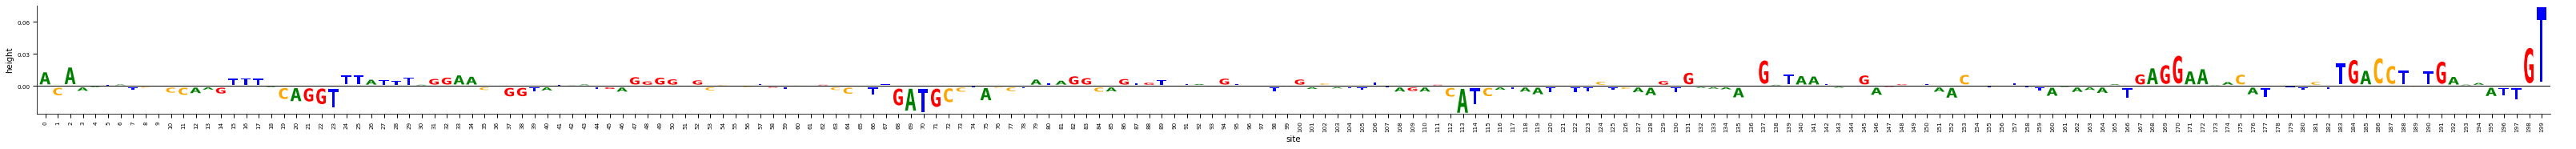

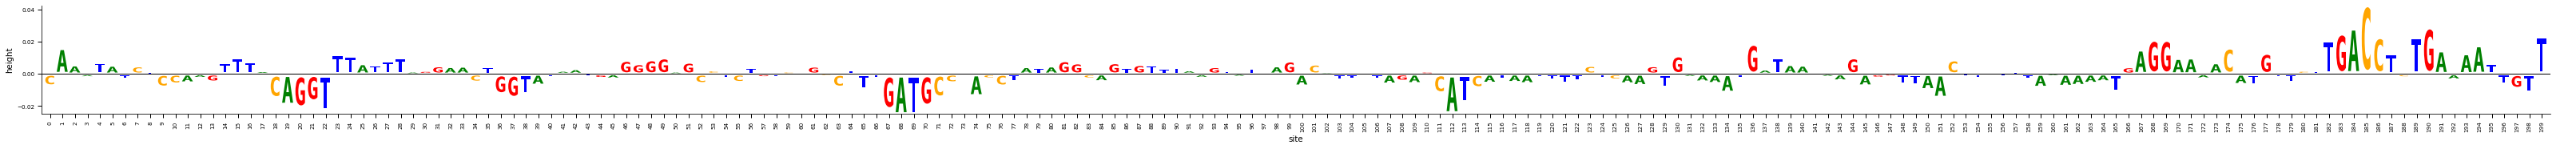

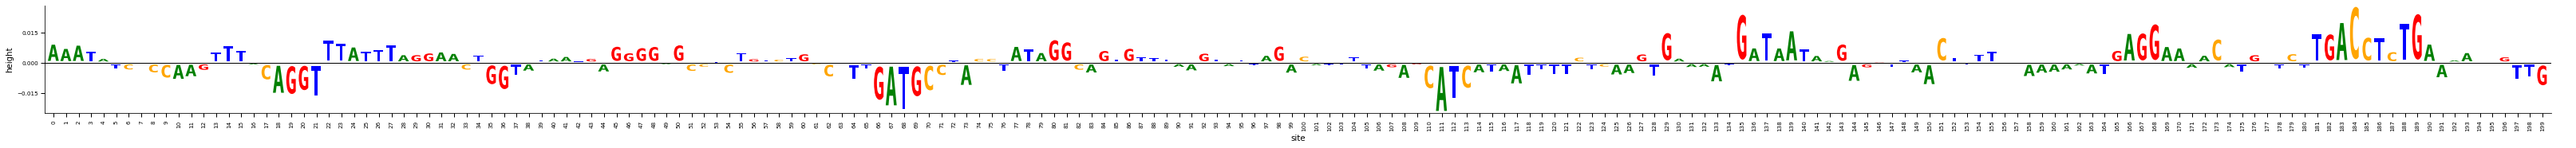

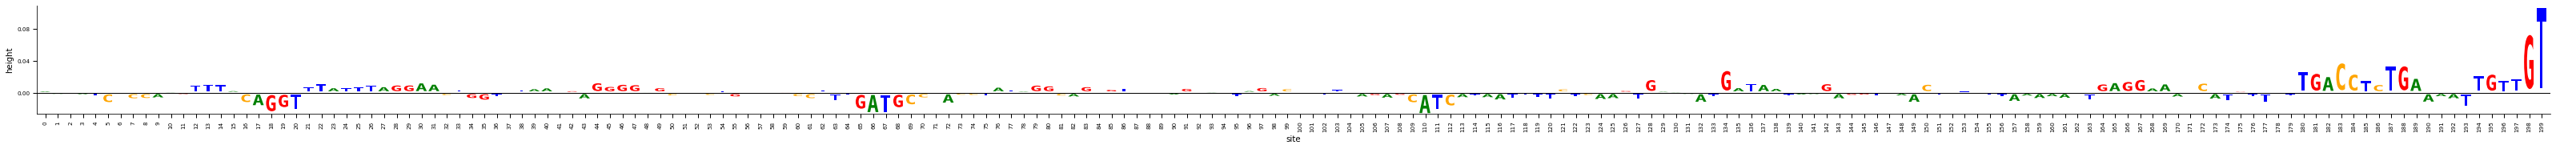

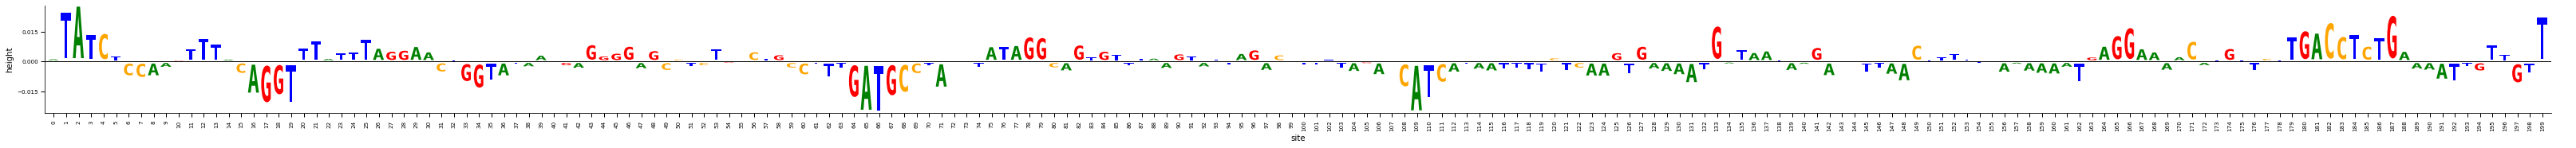

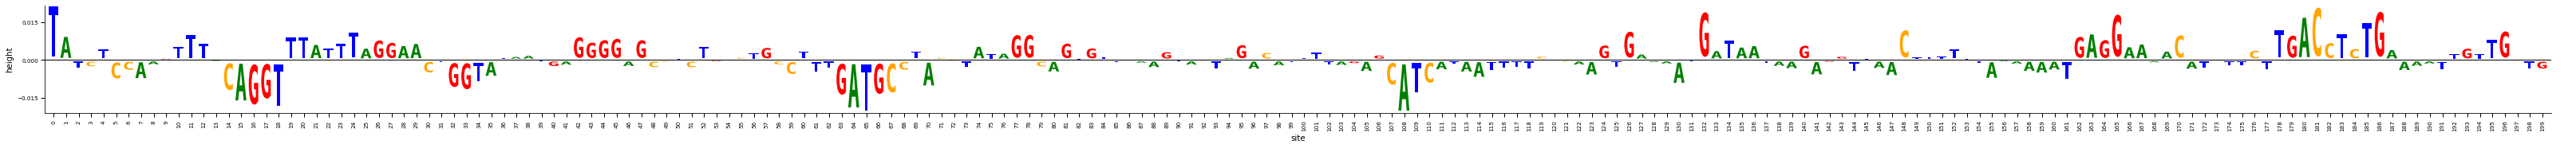

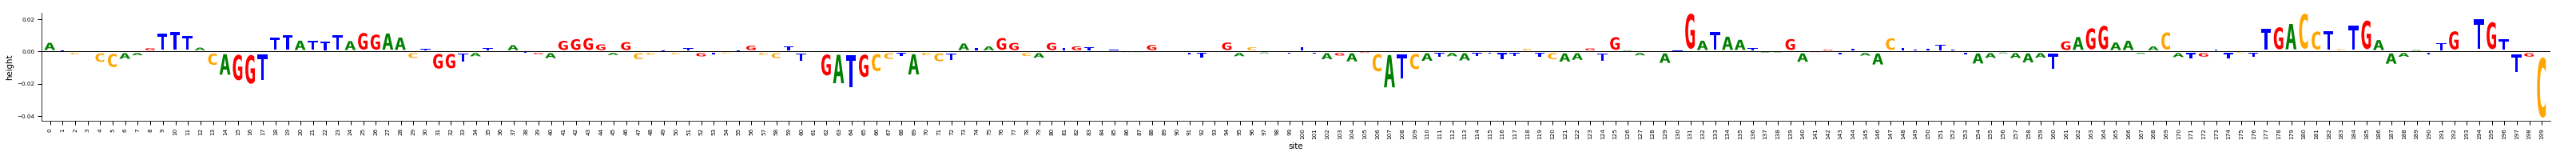

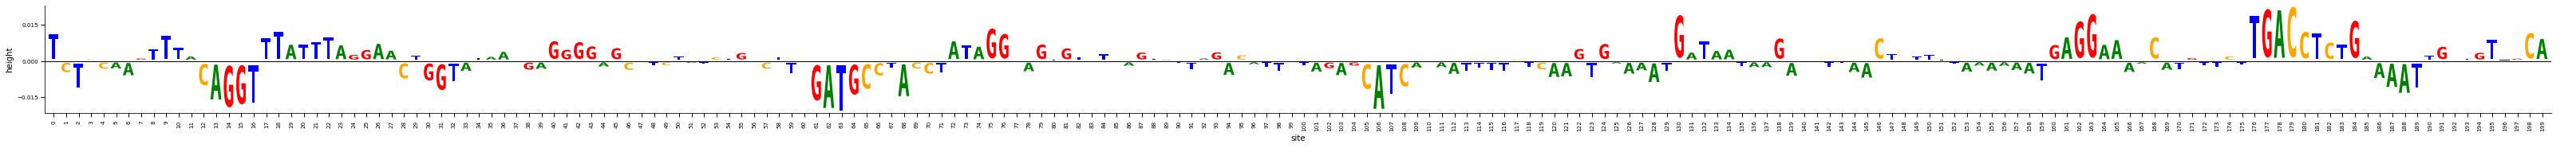

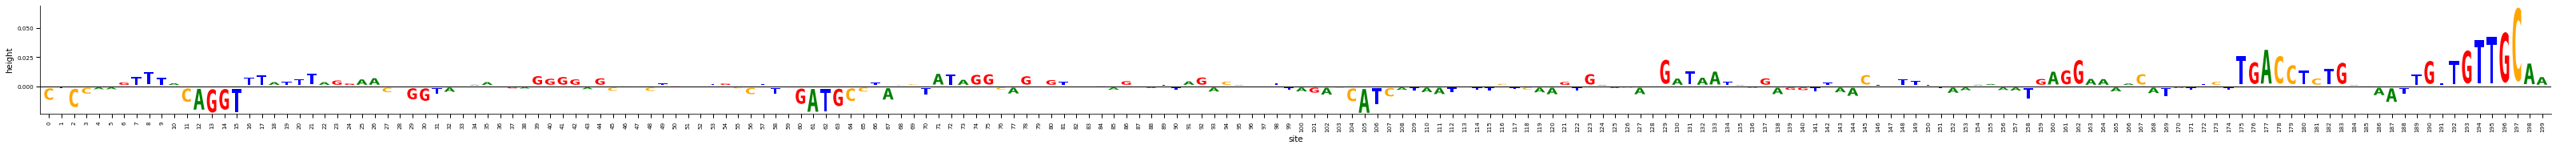

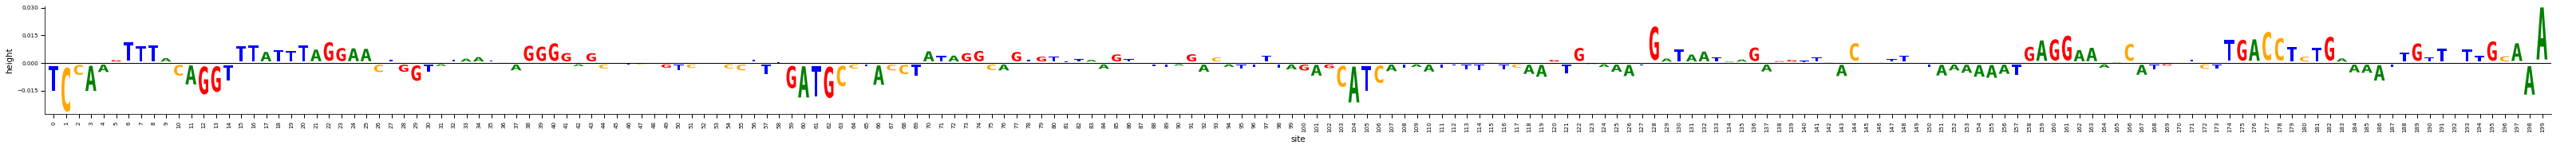

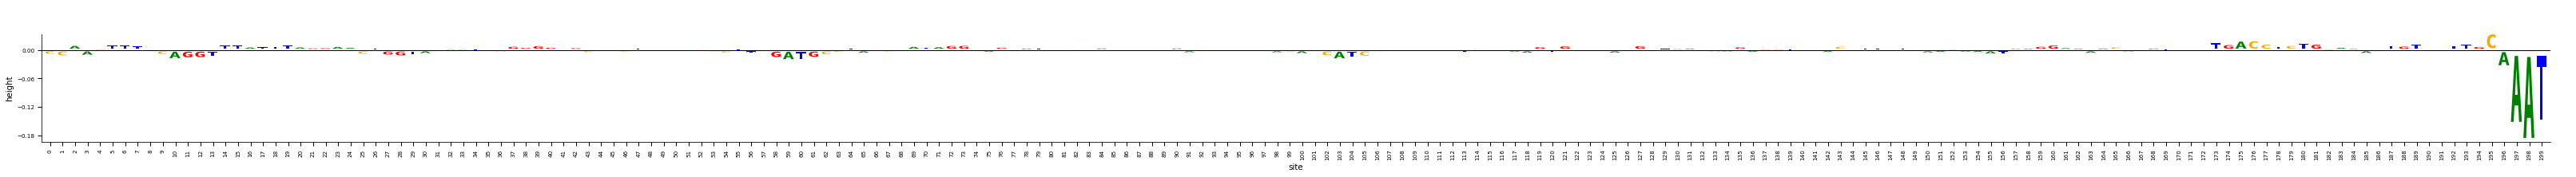

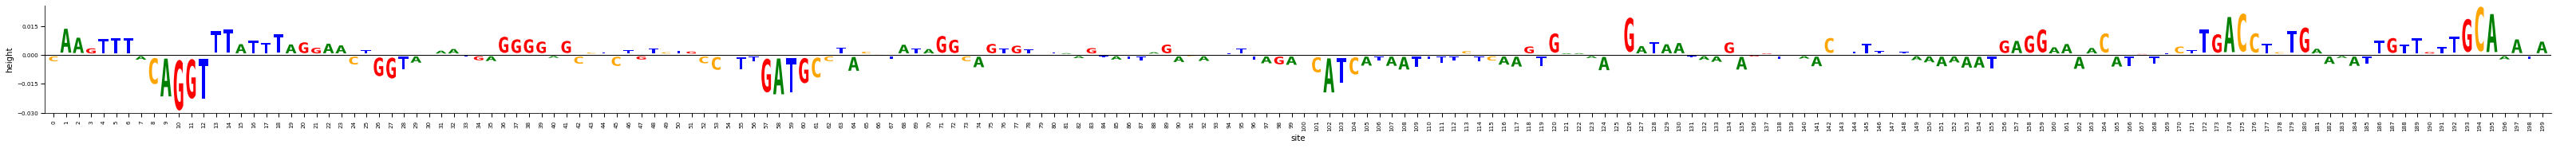

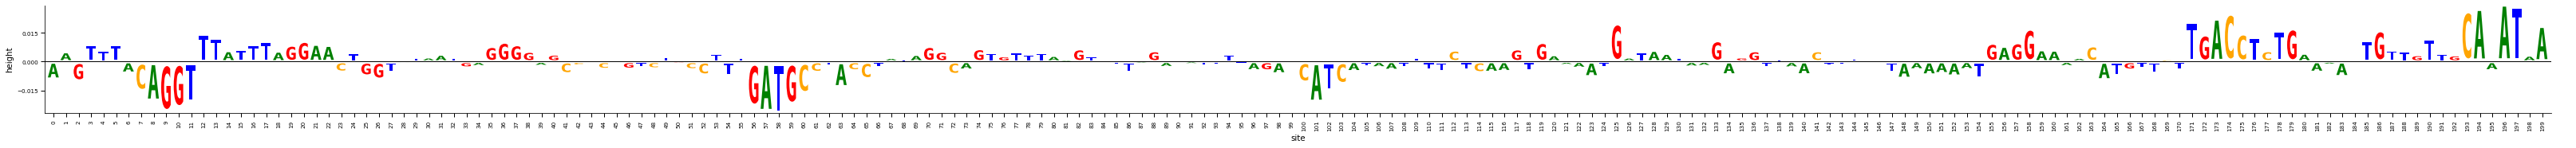

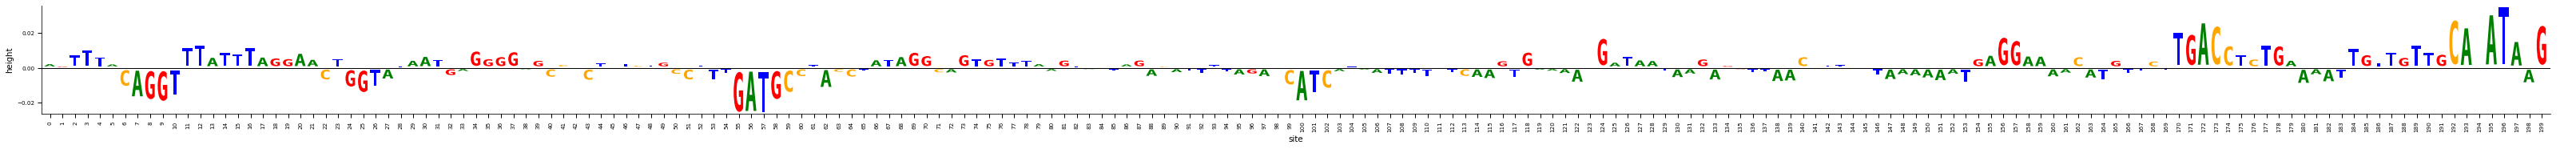

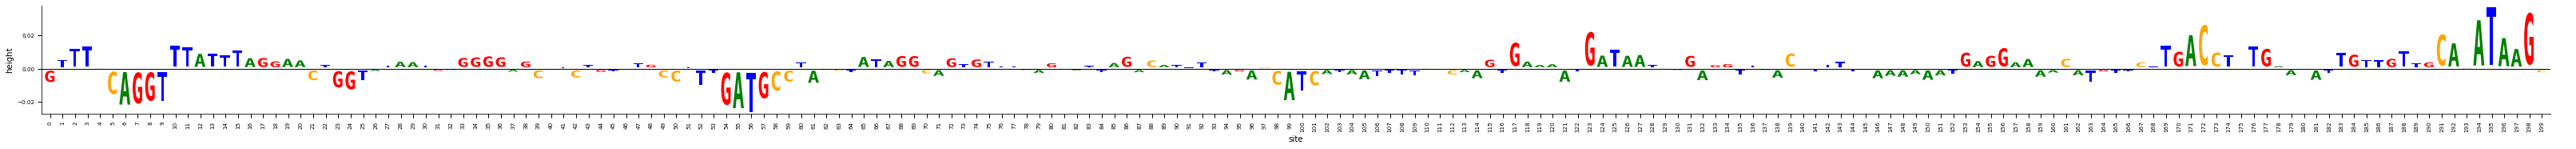

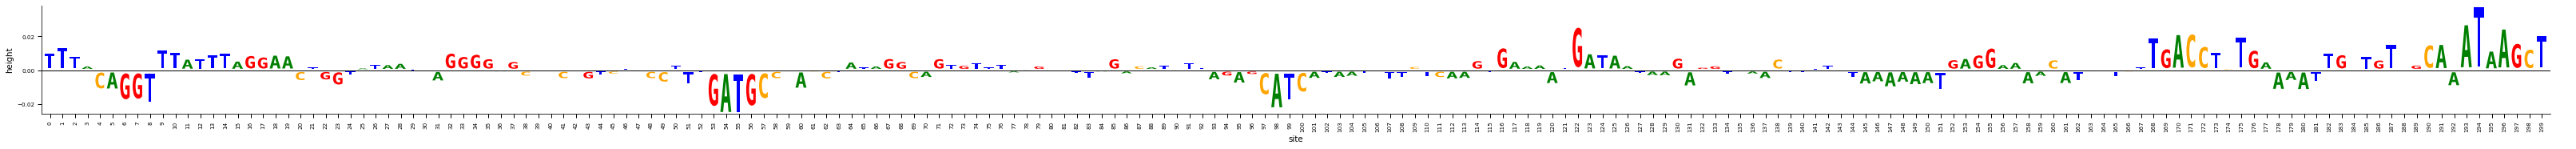

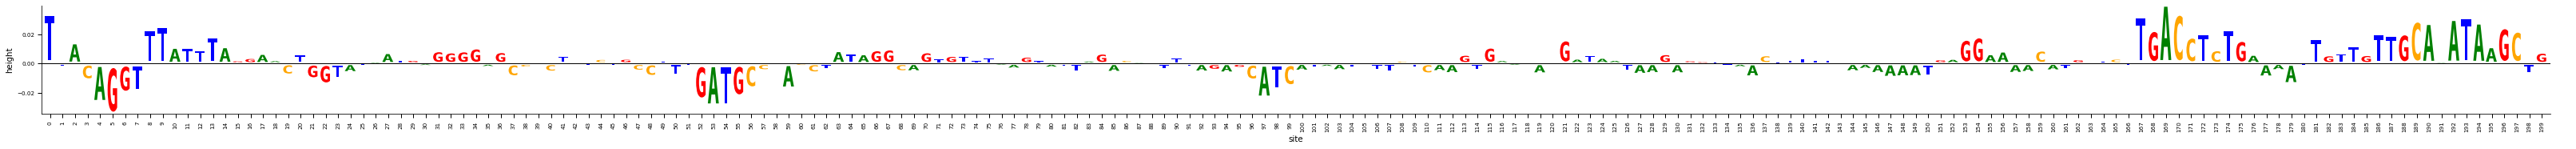

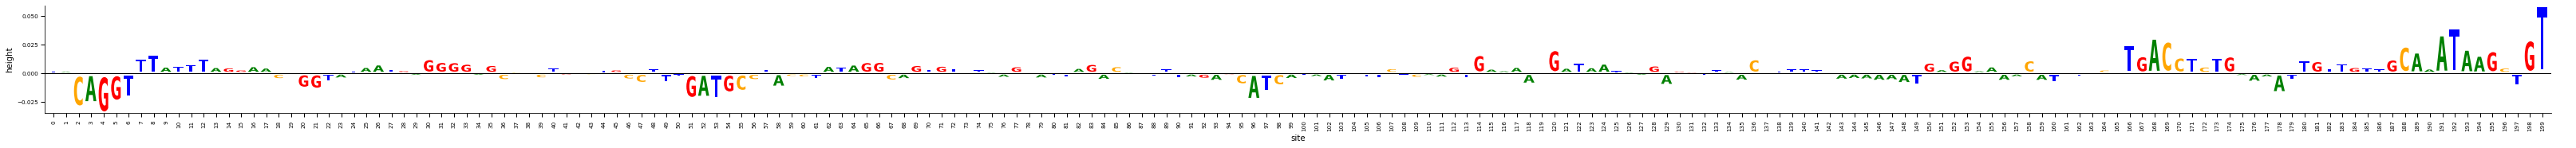

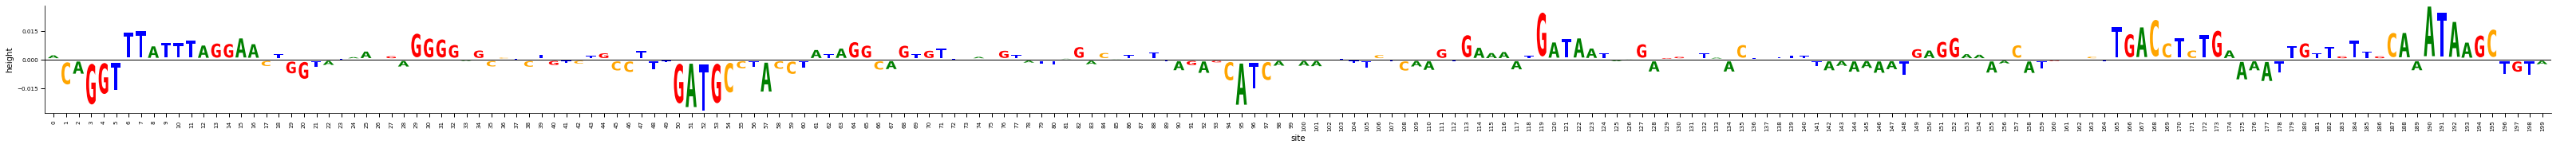

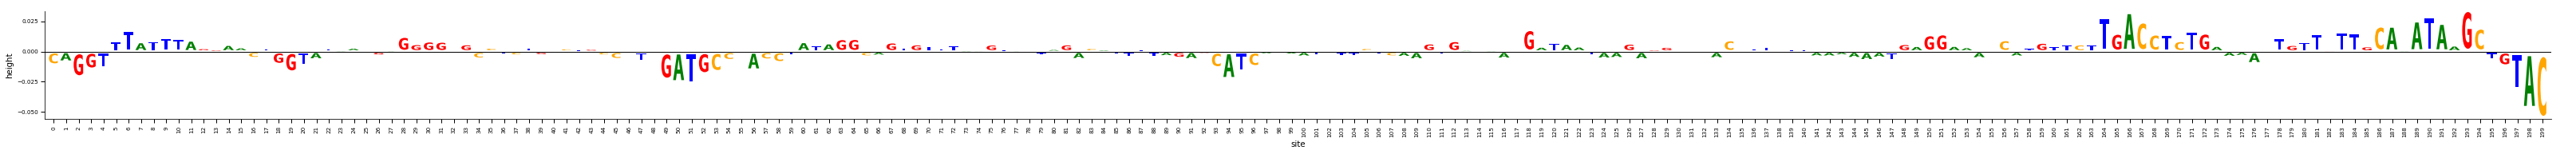

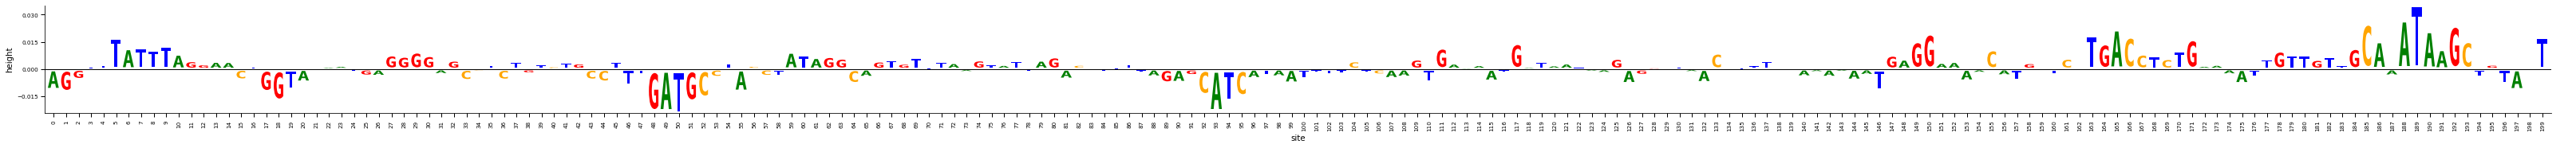

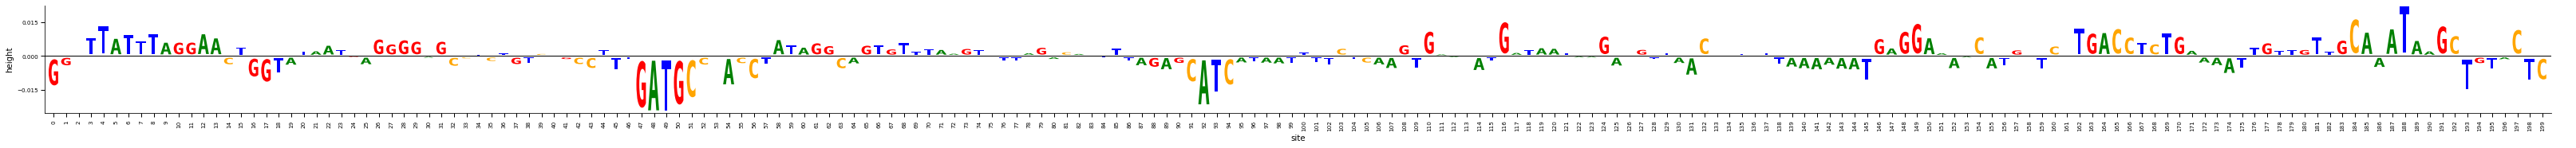

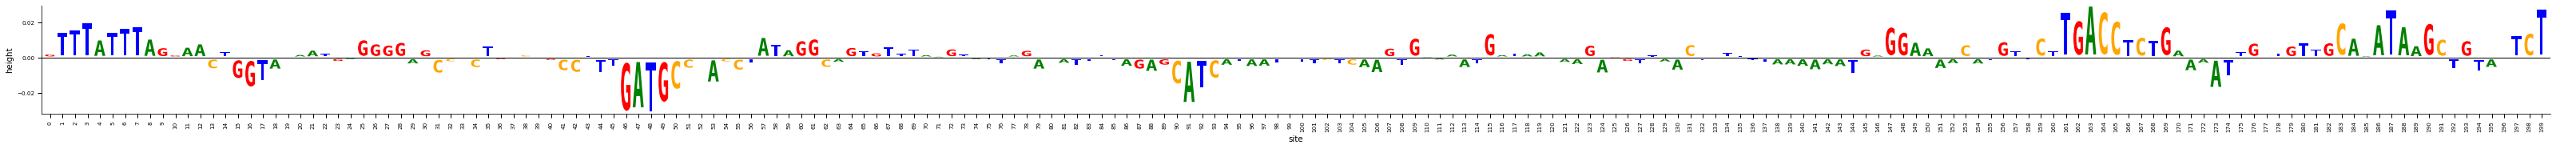

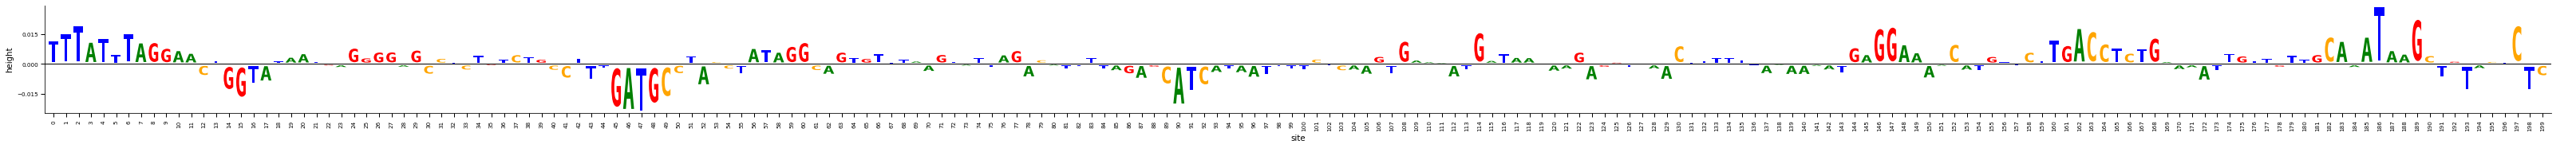

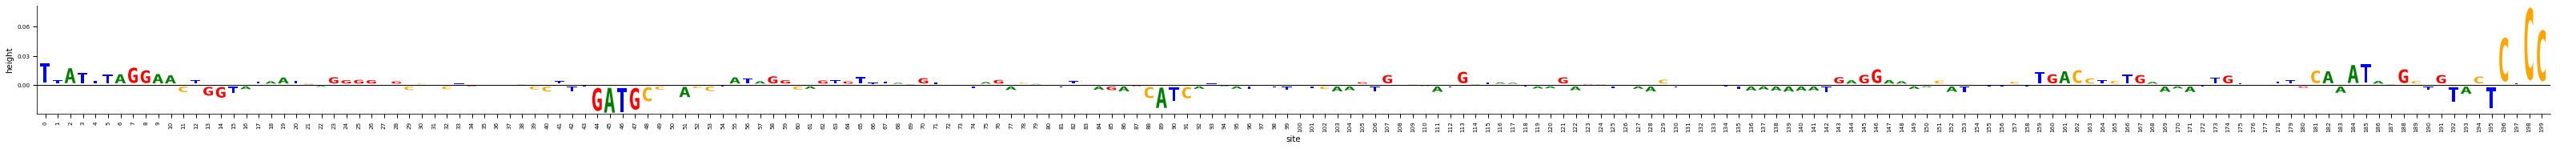

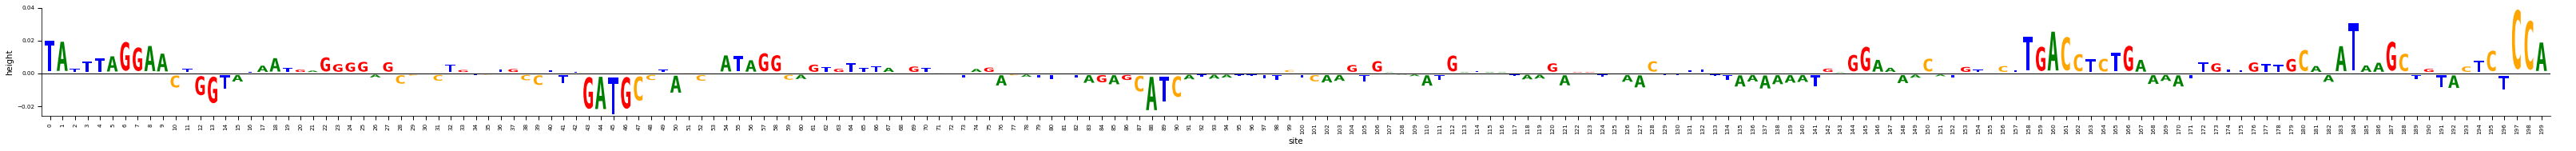

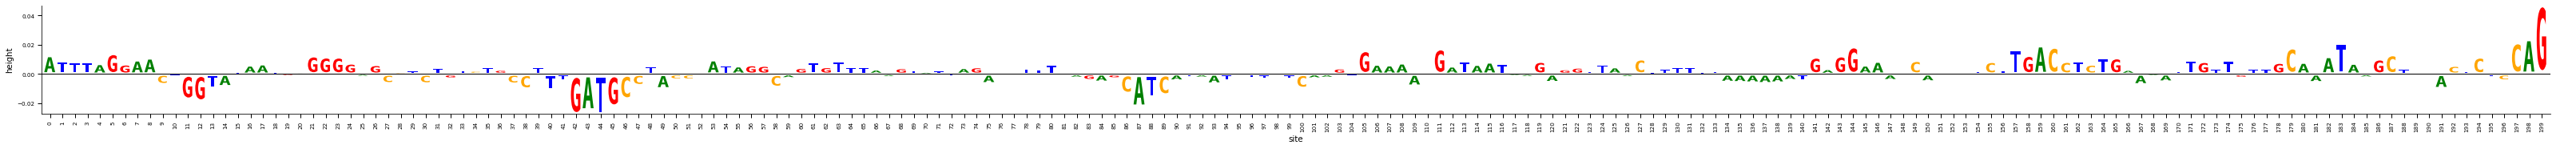

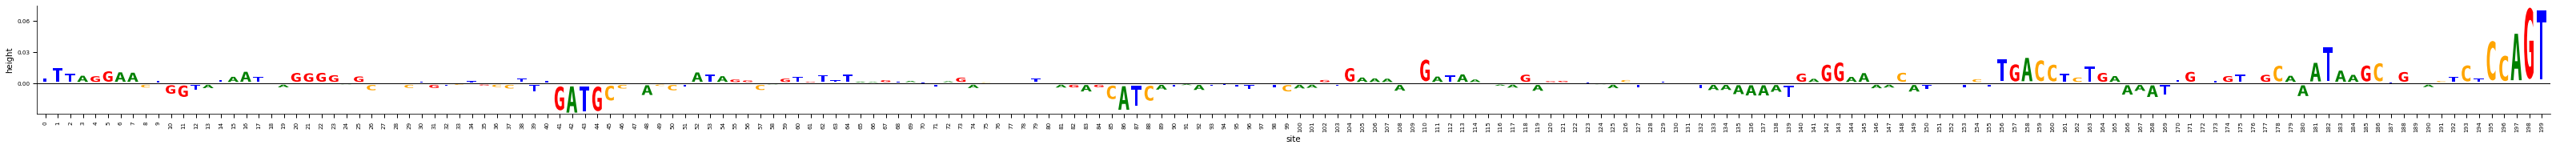

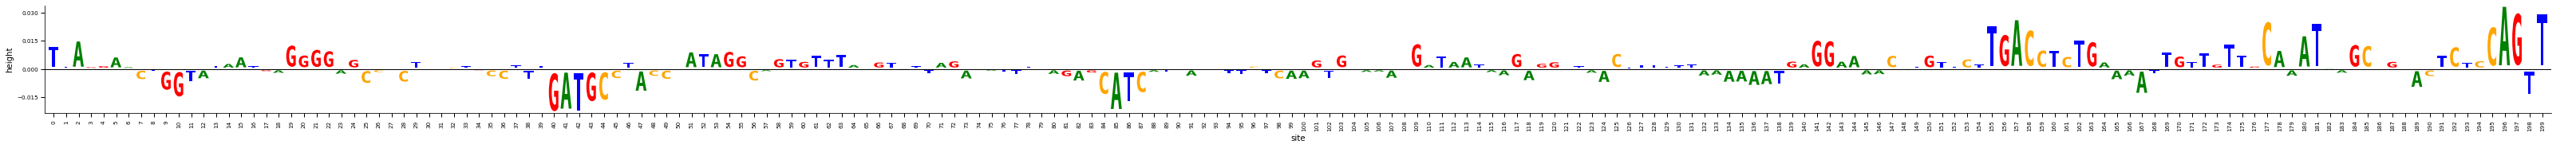

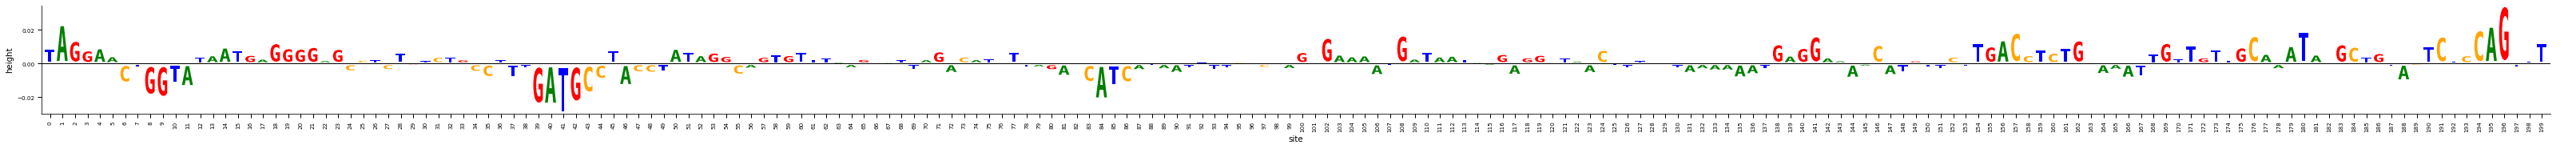

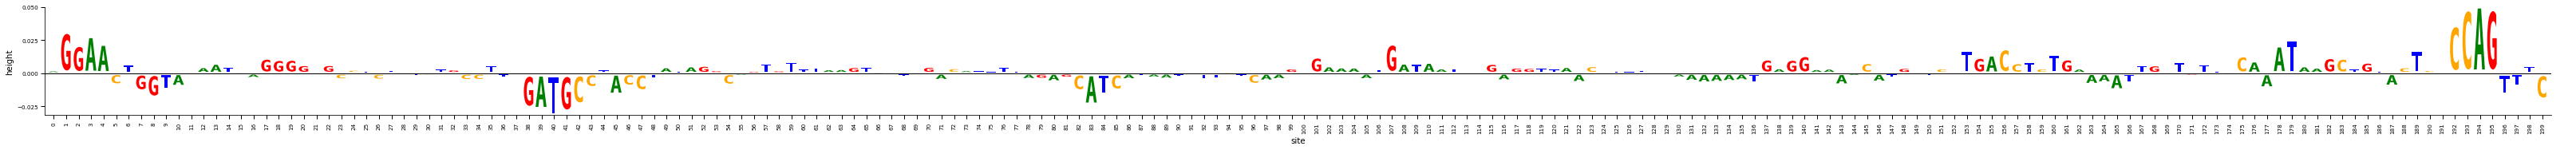

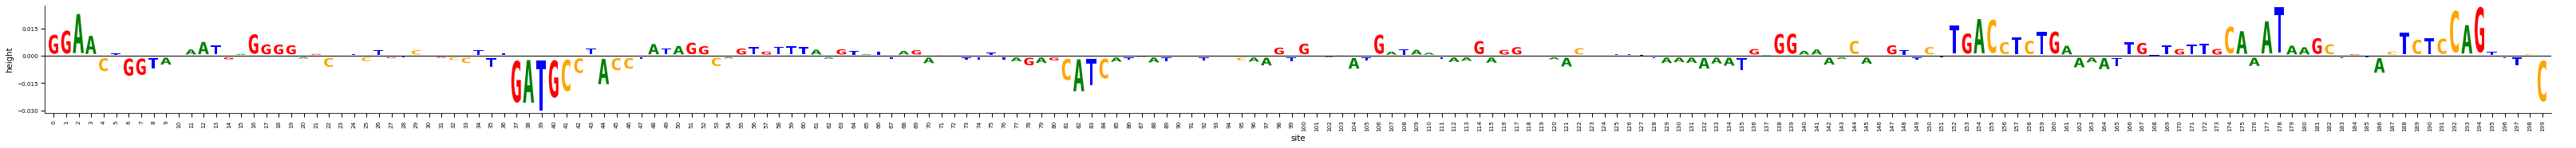

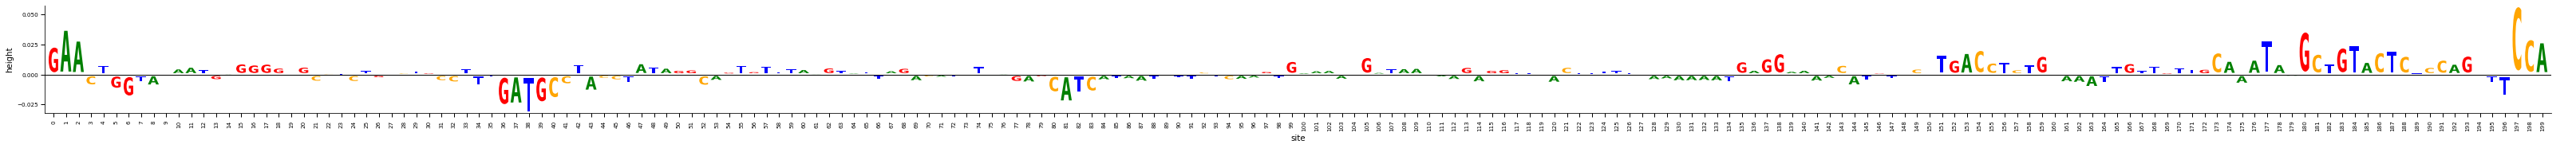

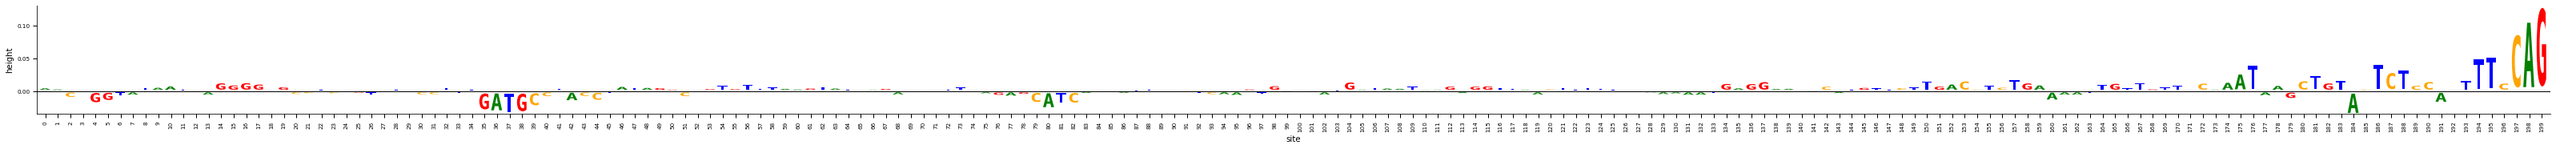

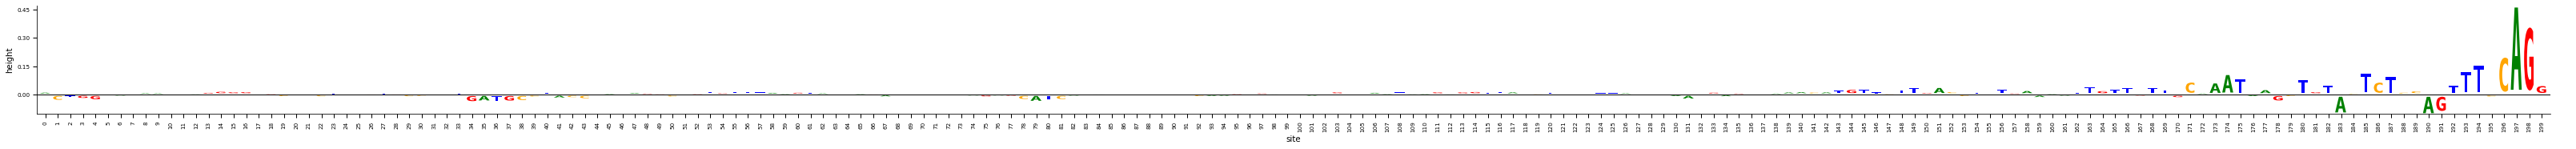

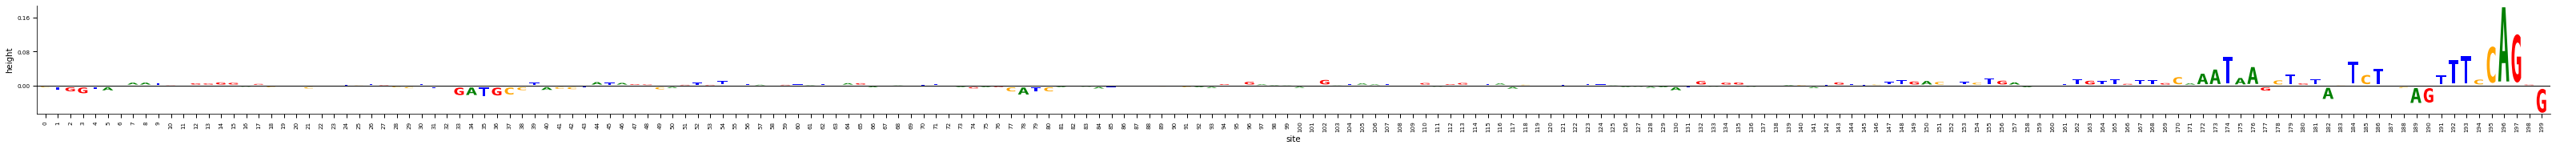

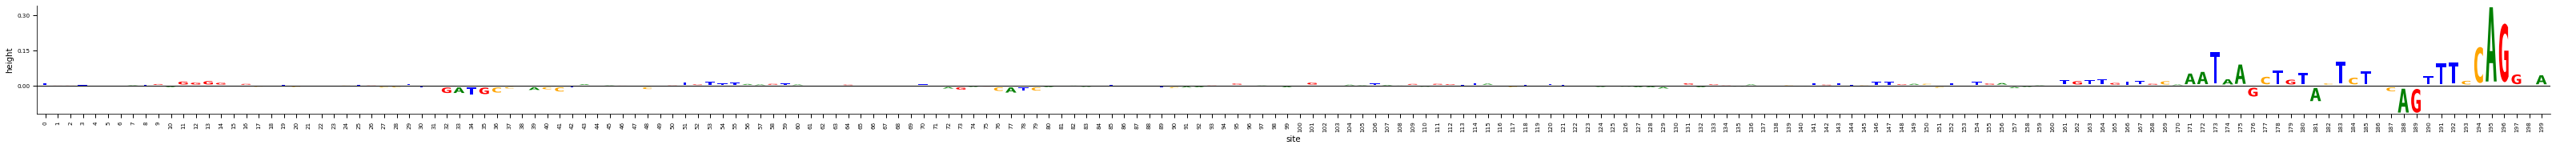

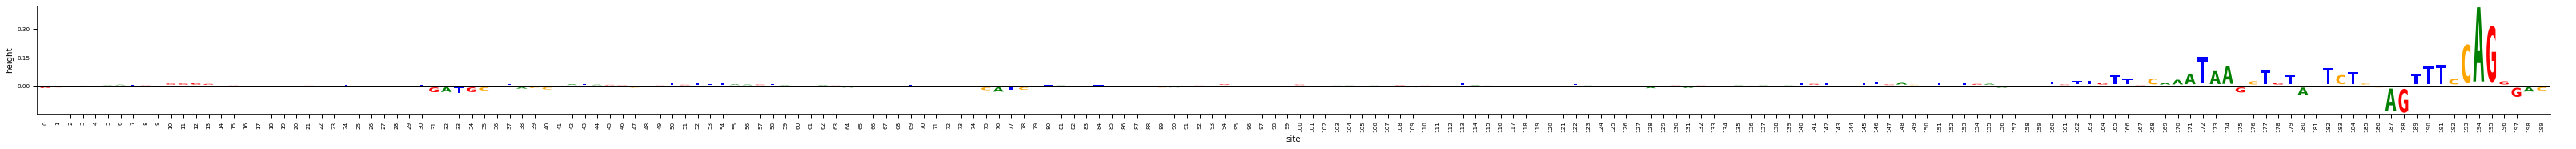

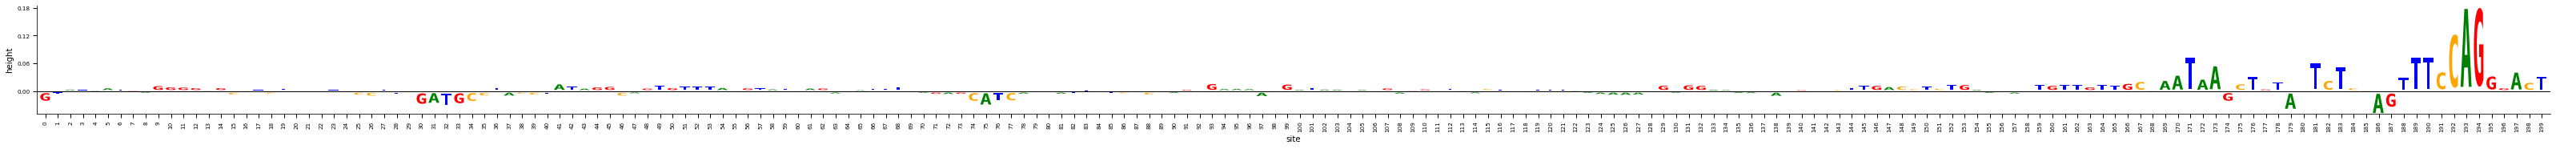

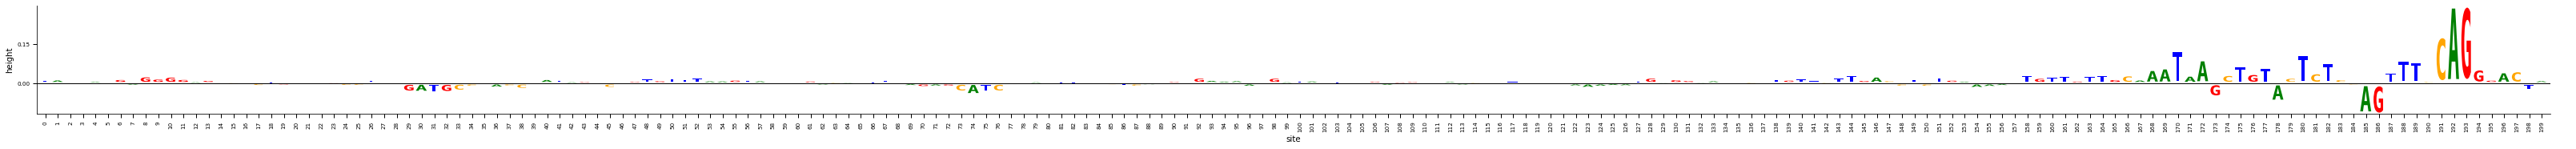

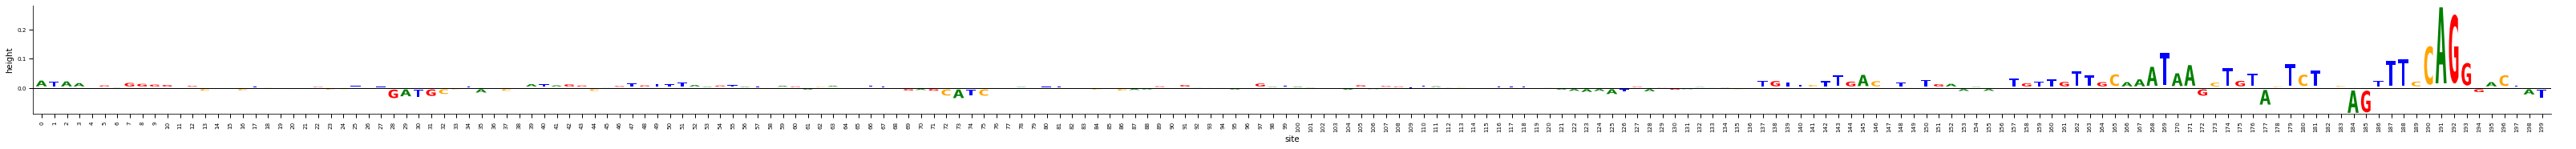

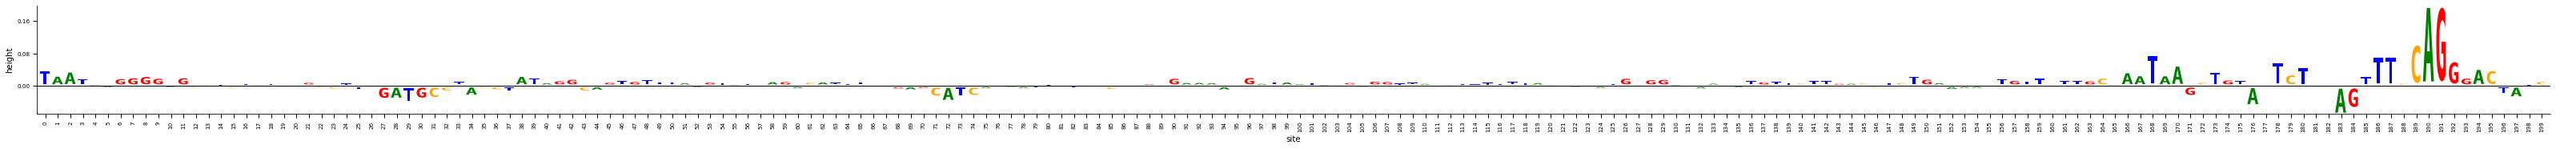

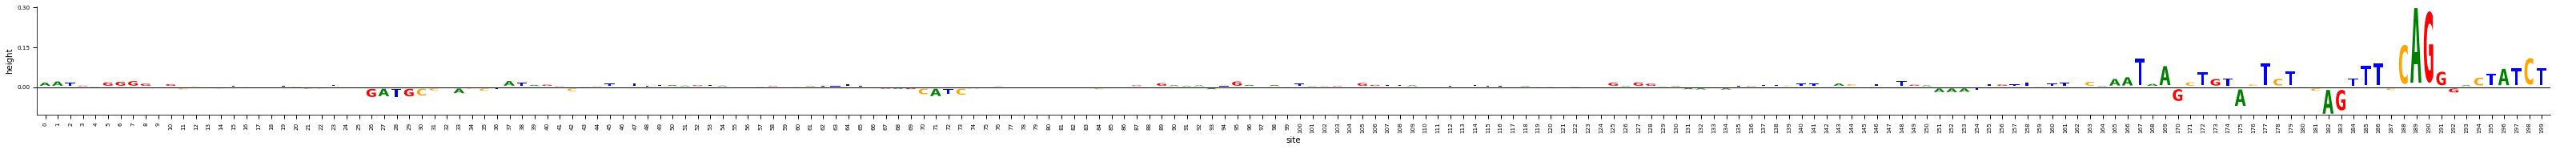

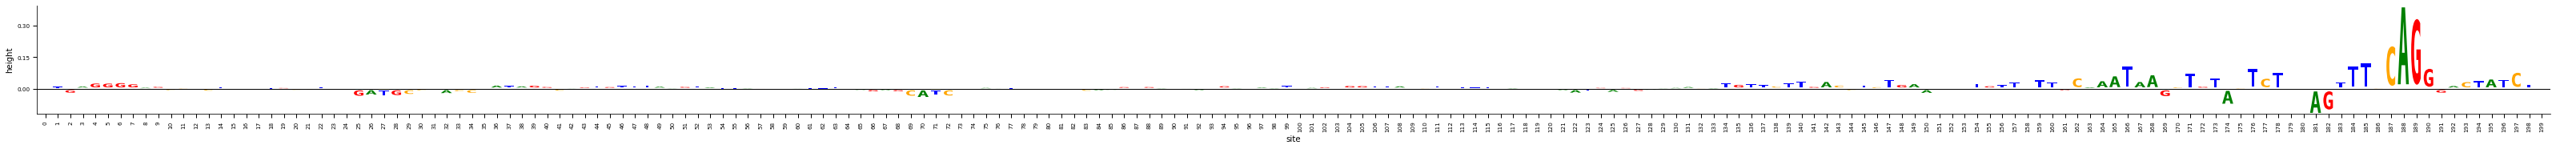

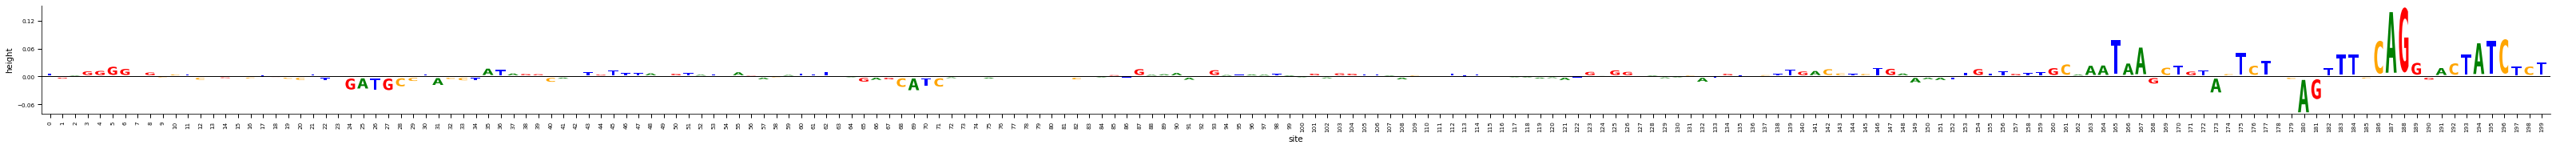

In [15]:
for i in range(65):
    matrix = salient_maps[i,:,:]
    y_max = matrix.max()
    fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
                      axisfontscale=0.6, heightscale=1)
    plt.show()

In [16]:
total_length = salient_maps.shape[0] + salient_maps.shape[-1]
full_window_contributions = []
for i in range(salient_maps.shape[0]):
    local_contributions = torch.zeros(4, total_length)
    local_contributions[:,i:i+salient_maps.shape[-1]] = salient_maps[i,:,:]
    full_window_contributions.append(local_contributions)
full_window_contributions = torch.stack(full_window_contributions)

divisors = torch.tensor(list(range(1,66)) + (200 - 65)*[65] + list(reversed(range(1,66))))
full_window_contributions = full_window_contributions.sum(dim=0).div(divisors)

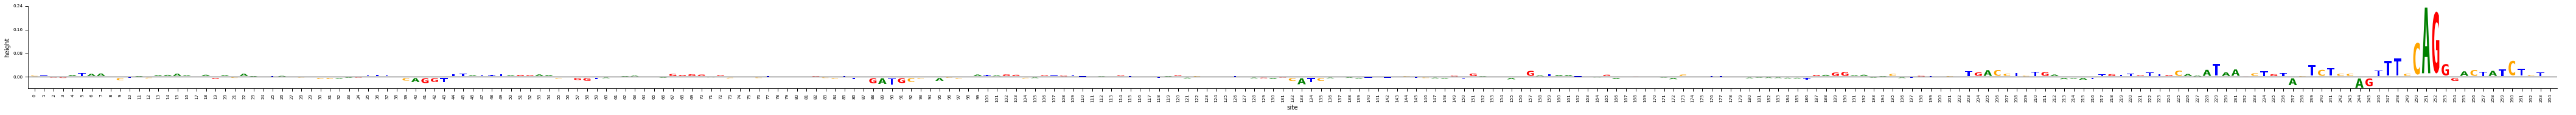

In [17]:
y_max = full_window_contributions.max()
fig, ax = matrix_to_dms(full_window_contributions, y_max=y_max, fontaspect=.65, widthscale=0.8,
                  axisfontscale=0.6, heightscale=1)
plt.show()

### Including flanks in salient maps

In [19]:
test_str = 'CTGGATAATCTACAAAATAGACAAATATCTCCAAGTTTACAGGTTTATTTAGGAACTGGTATAATGAGGGGAGCCTCTGTCTGCCTTTGATGCCTACCTATAGGCAGTGTTTAAGTATTAGACATTTTAGAGCATCATAATTTTCTCAAGTGAAAATGATAATAAGAGGTTAACTTTTTTAAAAAATGAGGAAAACATGTTCTTGACCTCTGAAAATTGTTGTTGCAAATAAGCTGTACTCTCCAGTTTCCAGGGACTATCTCTT'
window_size = 200

missing_len = 600 - window_size
left_idx = - missing_len//2 + missing_len%2
right_idx = missing_len//2 + missing_len%2
left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[left_idx:]).unsqueeze(0)
right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:right_idx]).unsqueeze(0) 
        
test_distributions = torch.stack([utils.dna2tensor(test_str[i:i+window_size]) for i in range(len(test_str)-window_size)])

pieces = [left_flank.repeat(test_distributions.shape[0], 1, 1), test_distributions, right_flank.repeat(test_distributions.shape[0], 1, 1)]
input_tensor = torch.cat( pieces, axis=-1)

In [29]:
predictor = mpra_predictor_no_flanks(model)
predictor.cuda()
attributer = IntegratedSampledGradients(input_tensor, predictor, num_samples=20)
attributer.cuda()

IntegratedSampledGradients(
  (predictor): mpra_predictor_no_flanks(
    (model): BassetBranched(
      (pad1): ConstantPad1d(padding=(9, 9), value=0.0)
      (conv1): Conv1dNorm(
        (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
        (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (pad2): ConstantPad1d(padding=(5, 5), value=0.0)
      (conv2): Conv1dNorm(
        (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
        (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (pad3): ConstantPad1d(padding=(3, 3), value=0.0)
      (conv3): Conv1dNorm(
        (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
        (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
      (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_

In [ ]:
all_preds = predictor(input_tensor.cuda()).cpu().detach().numpy()

In [60]:
salient_maps = attributer.get_salient_maps(num_steps=100, num_samples=1).cpu()

100%|██████████| 101/101 [00:16<00:00,  6.08it/s]


In [44]:
gradients = attributer.integrate_gradients(num_steps=100, num_samples=20).cpu()

100%|██████████| 101/101 [00:12<00:00,  7.89it/s]


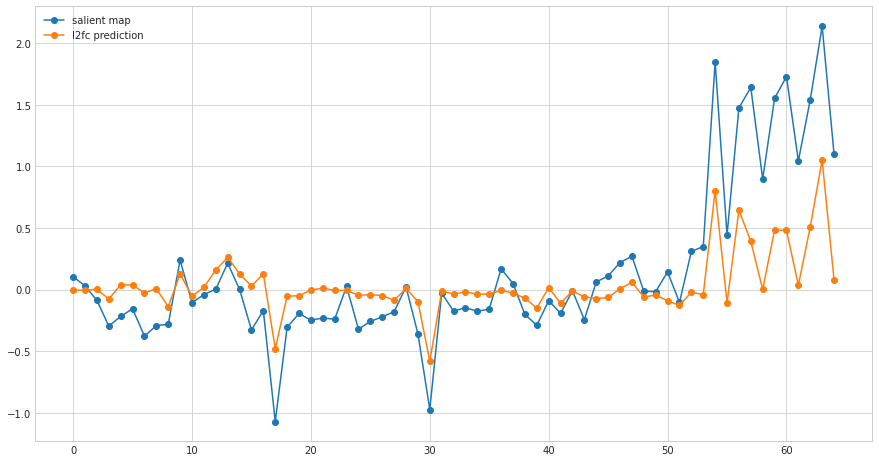

In [61]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(15,8))
    plt.plot(salient_maps.sum(dim=-1).sum(dim=-1), label='salient map', linestyle='-', marker='o')    
    plt.plot(all_preds, label='l2fc prediction', linestyle='-', marker='o')
    #plt.plot(gradients.sum(dim=-1).sum(dim=-1), label='gradients', linestyle='-', marker='o')
    plt.legend()
    plt.show()

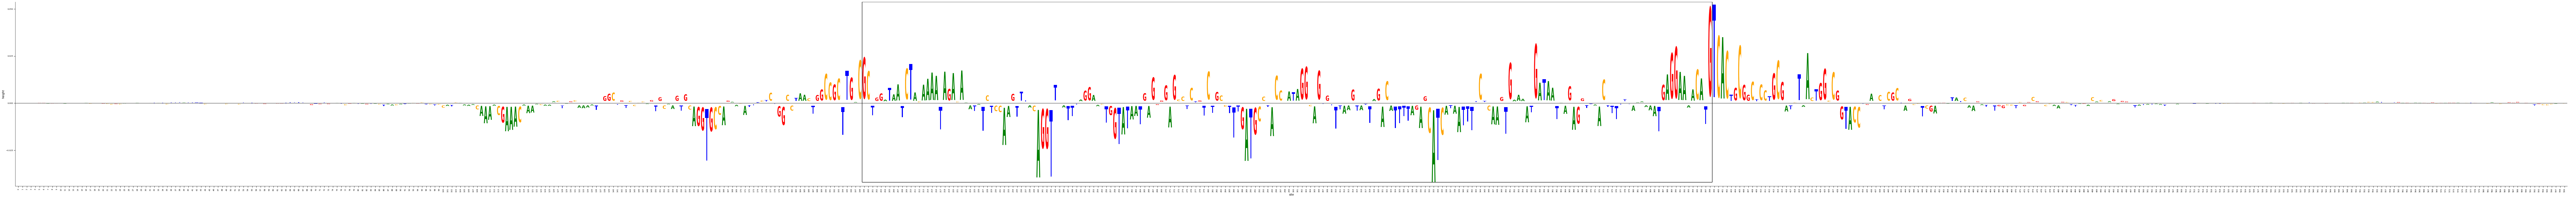

In [47]:
matrix = salient_maps[0,:,:]
y_max = matrix.max()
y_min = matrix.min()
fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
                  axisfontscale=0.6, heightscale=5)
plt.vlines(199, y_min, y_max, colors='black')
plt.vlines(399, y_min, y_max, colors='black')
plt.hlines(y_max, 199, 399, colors='black')
plt.hlines(y_min, 199, 399, colors='black')
plt.show()

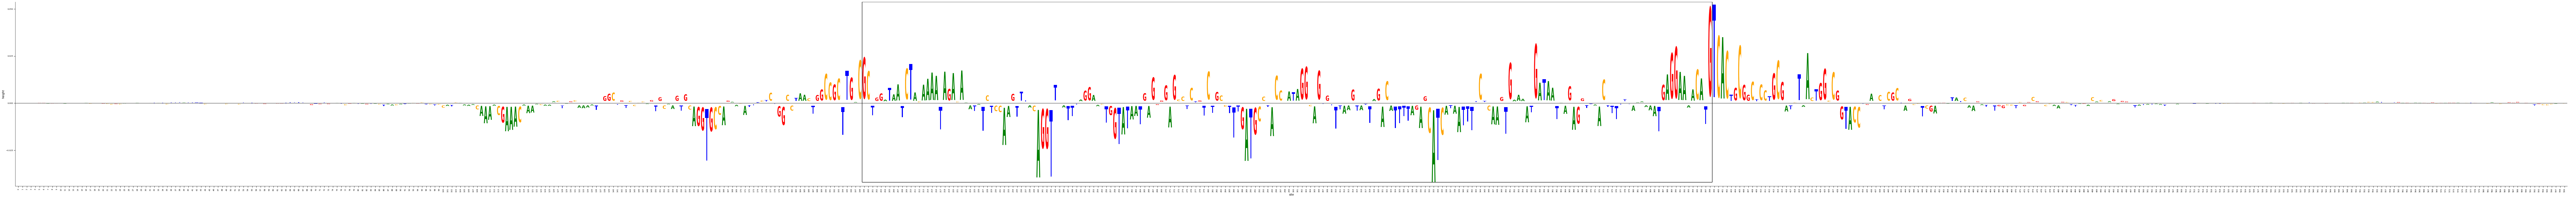

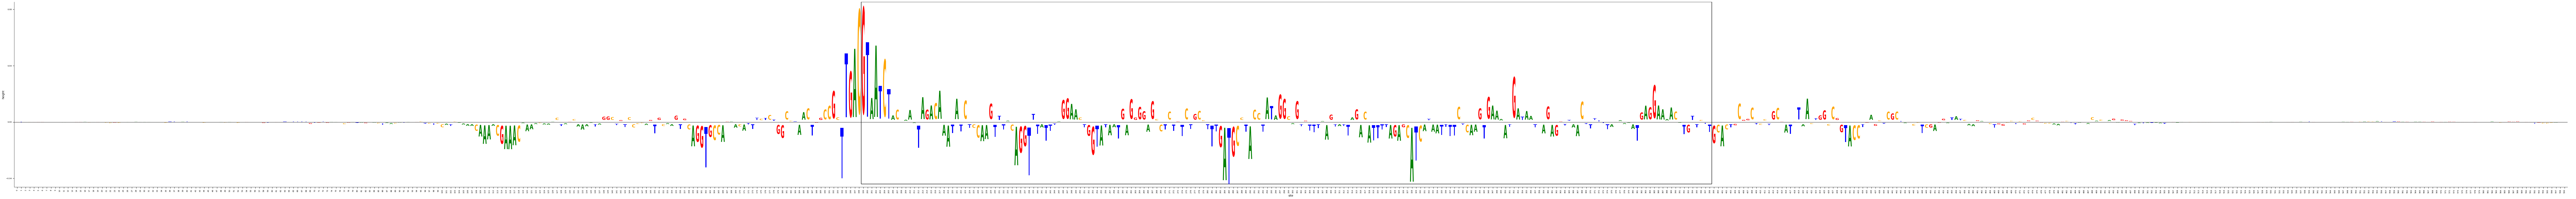

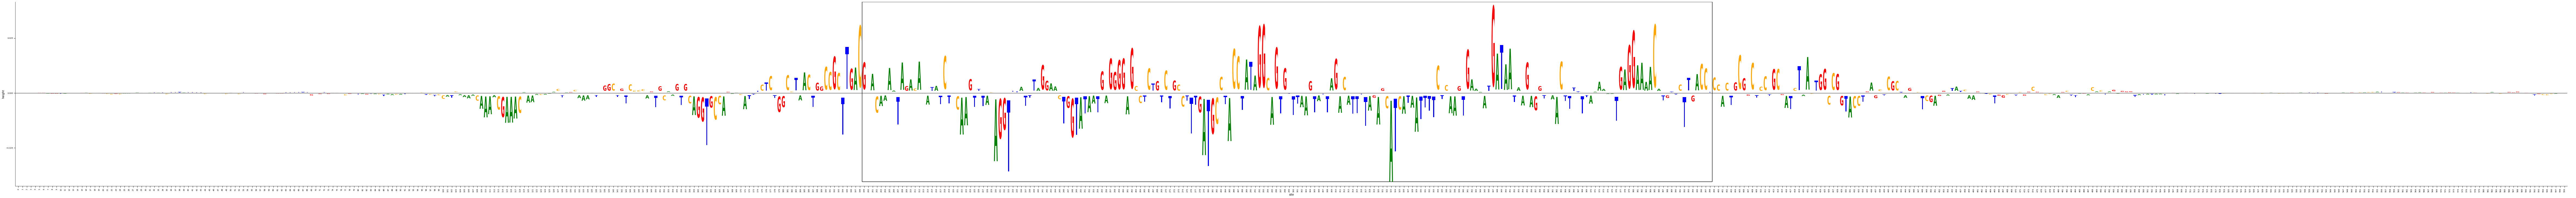

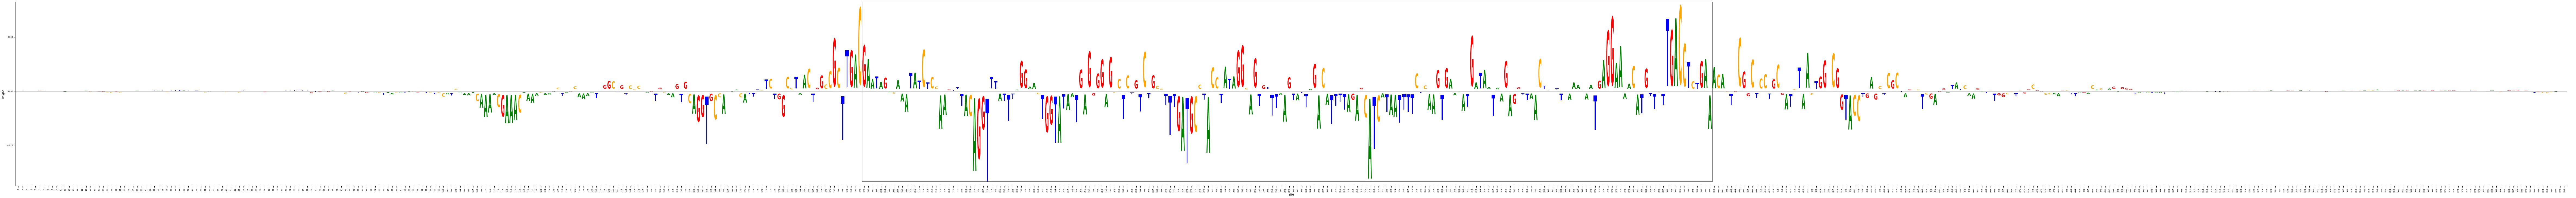

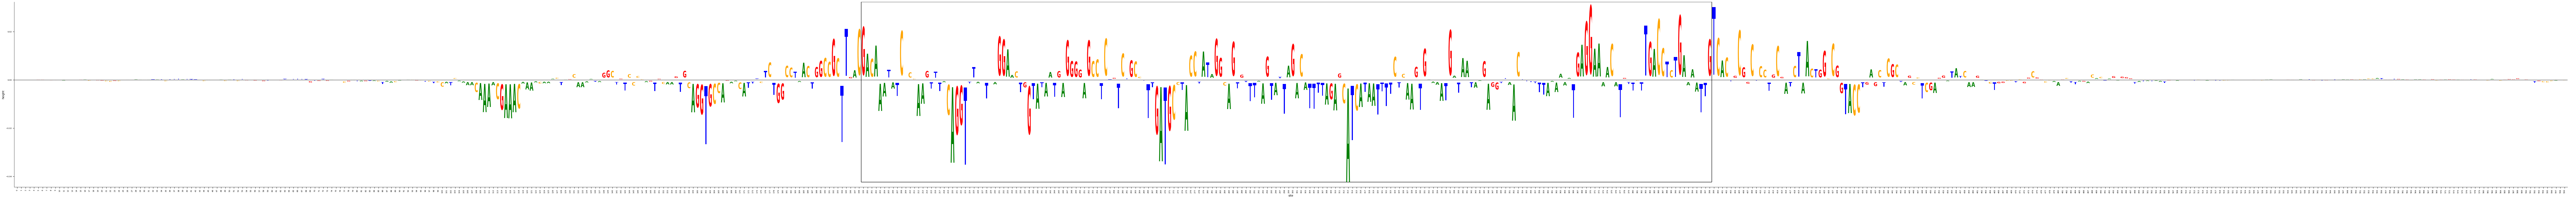

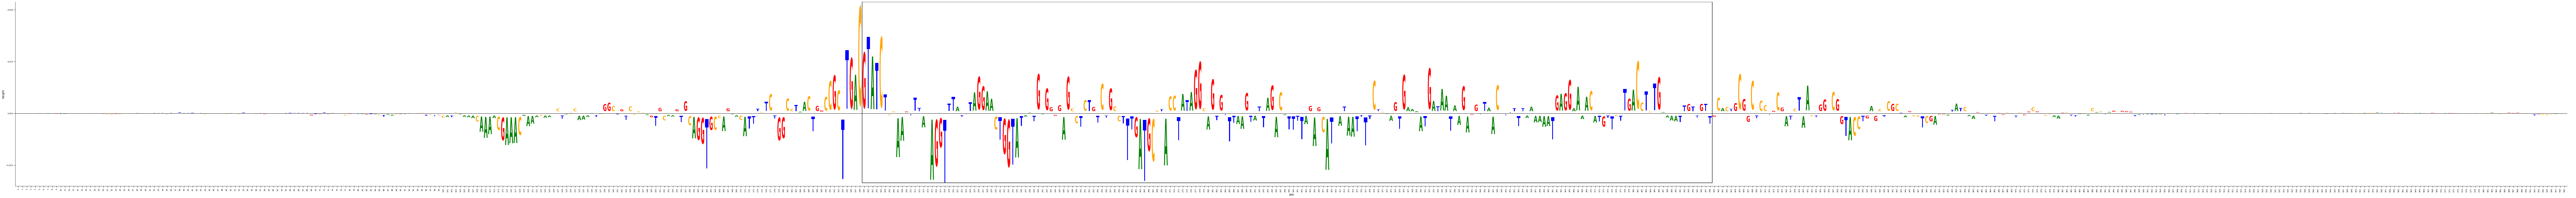

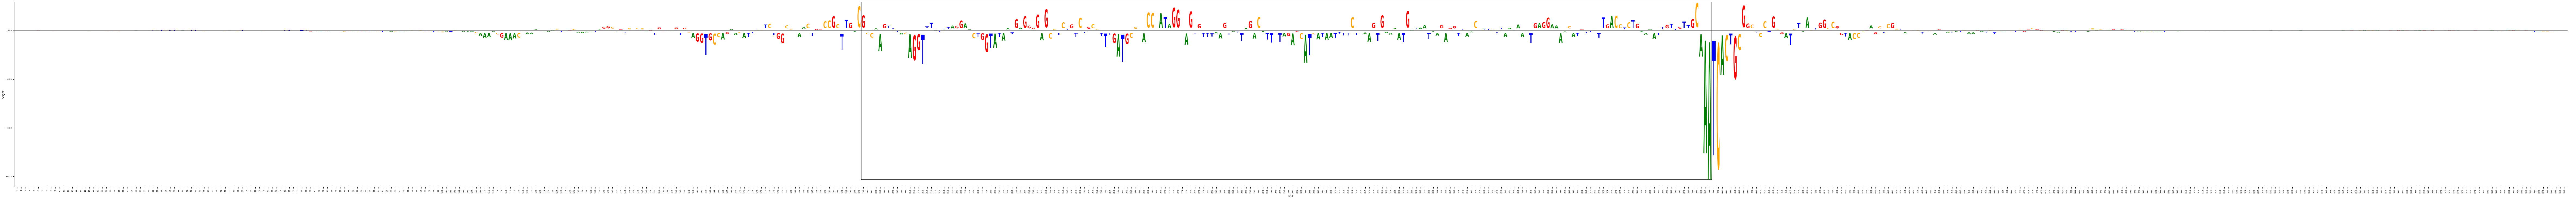

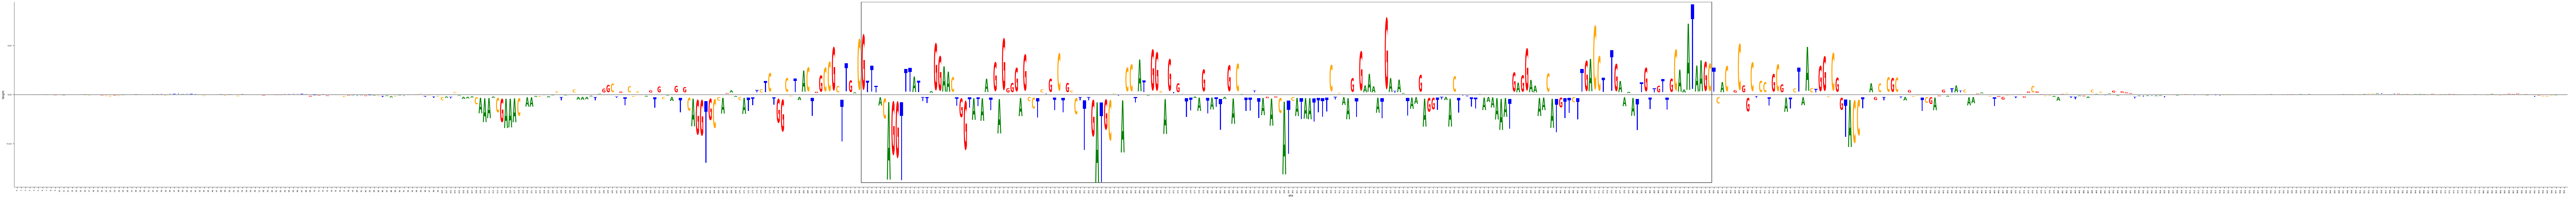

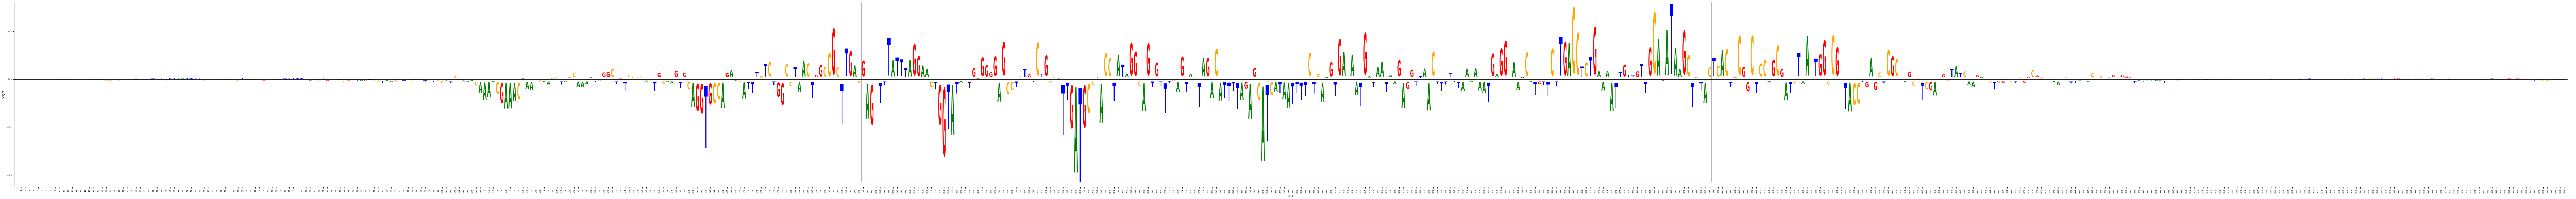

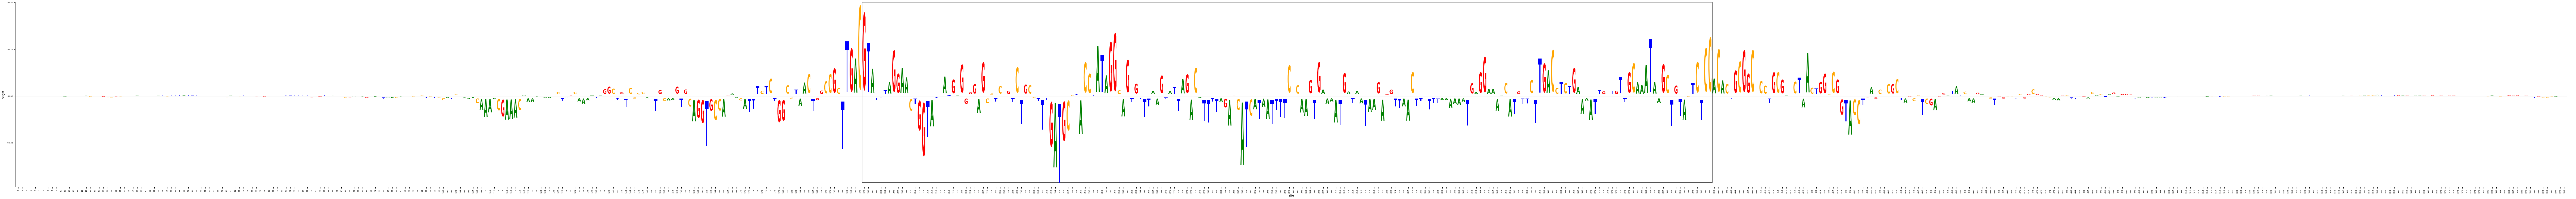

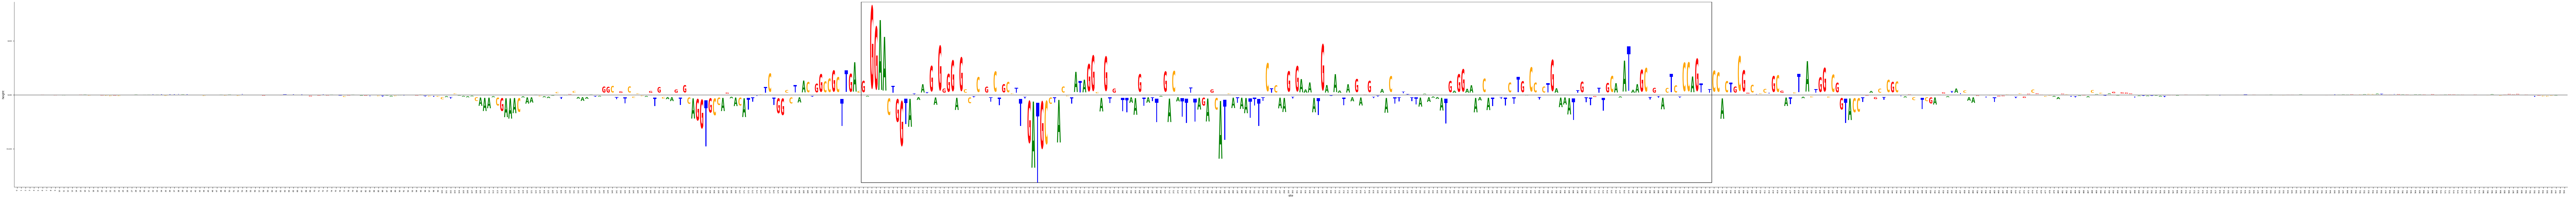

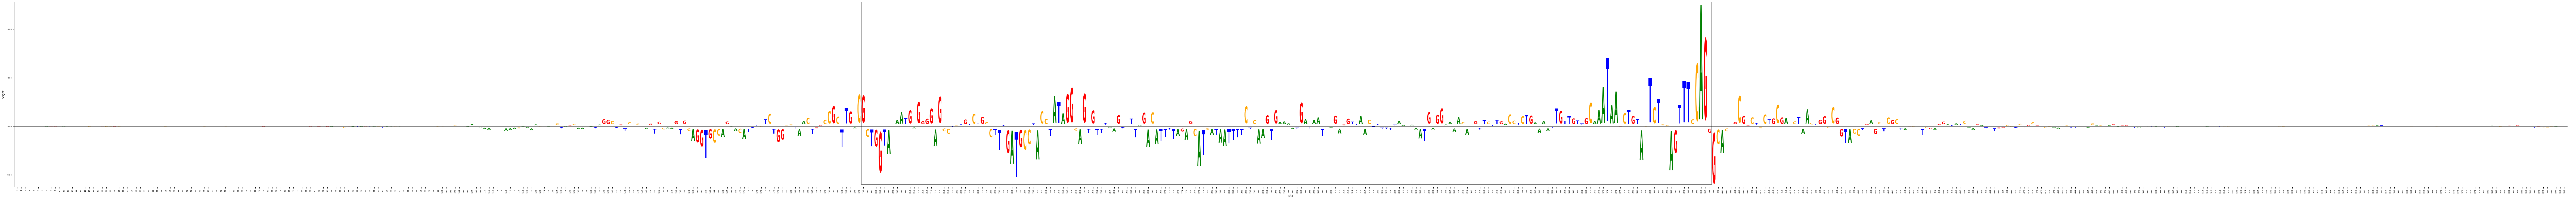

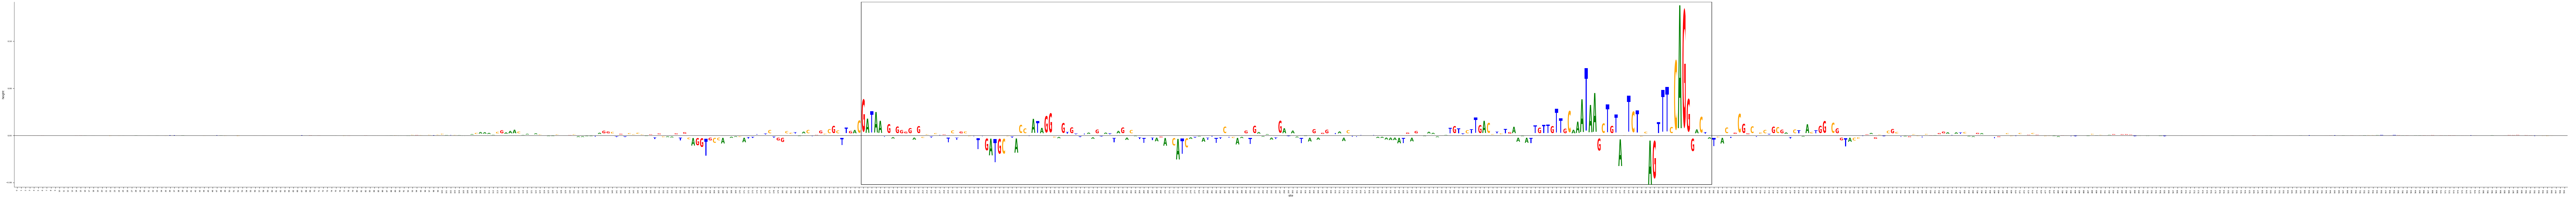

In [49]:
for i in range(0,65,5): #range(salient_maps.shape[0]):
    matrix = salient_maps[i,:,:]
    y_max = matrix.max()
    y_min = matrix.min()
    fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
                      axisfontscale=0.6, heightscale=5)
    plt.vlines(199, y_min, y_max, colors='black')
    plt.vlines(399, y_min, y_max, colors='black')
    plt.hlines(y_max, 199, 399, colors='black')
    plt.hlines(y_min, 199, 399, colors='black')
    plt.show()

## Analyzing batches of generated sequences

In [5]:
def fasta_to_tensor(file_name):
    fasta_dict = {}
    with open(file_name, 'r') as f:
        for line in f:
            line_str = str(line)
            if line_str[0] == '>':
                my_id = line_str.lstrip('>').rstrip('\n')
                fasta_dict[my_id] = ''
            else:
                fasta_dict[my_id] += line_str.rstrip('\n')
    seq_tensors = []
    for sequence in list(fasta_dict.values()):
        seq_tensors.append(utils.dna2tensor(sequence))
    return torch.stack(seq_tensors, dim=0)

In [6]:
#! gsutil cp gs://syrgoth/data/design_tests/K562_first_round__simulated_annealing.fa ./   
#! gsutil cp gs://syrgoth/data/design_tests/HepG2_first_round__simulated_annealing.fa ./ 

k562_batch = fasta_to_tensor('K562_first_round__simulated_annealing.fa')
hepg2_batch = fasta_to_tensor('HepG2_first_round__simulated_annealing.fa')

In [7]:
k562_predictor = mpra_predictor(model=model, pred_idx=0, ini_in_len=200).cuda()
hepg2_predictor = mpra_predictor(model=model, pred_idx=1, ini_in_len=200).cuda()
sknsh_predictor = mpra_predictor(model=model, pred_idx=2, ini_in_len=200).cuda()

In [8]:
#batch = k562_batch[:20, ...]
batch = hepg2_batch[:5, ...]

predictors = [k562_predictor, hepg2_predictor, sknsh_predictor]

attributers = [IntegratedSampledGradients(batch, predictor, num_samples=20).cuda() for predictor in predictors]
all_predictions = []
all_salient_maps = []
for idx, predictor in enumerate(predictors):
    all_predictions.append(predictor(batch.cuda()))
    all_salient_maps.append(attributers[idx].get_salient_maps(num_steps=100, num_samples=20).cpu())

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 101/101 [00:01<00:00, 85.98it/s]



------------------------------ Sequence 1 ------------------------------



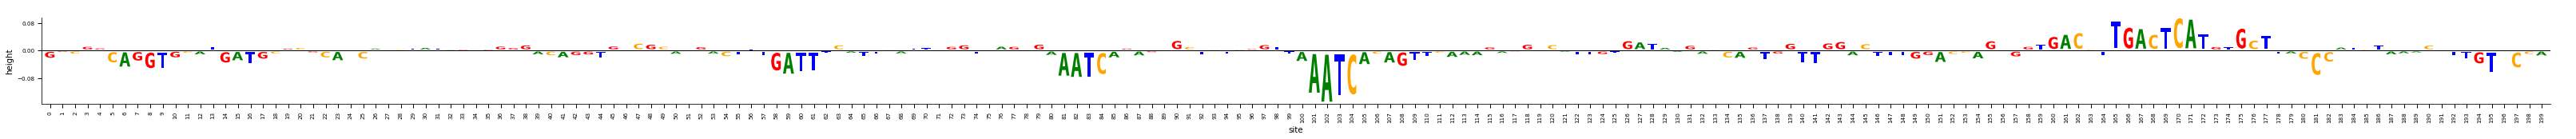

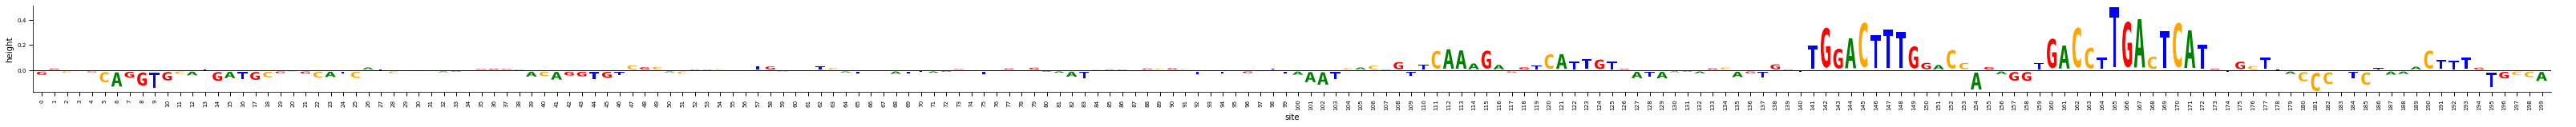

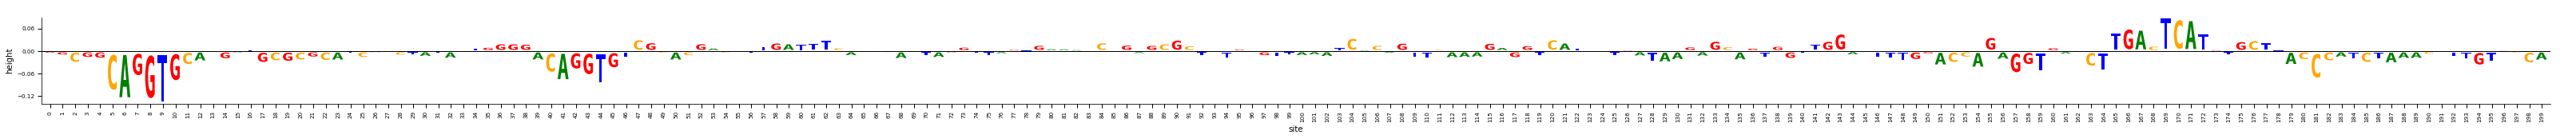


------------------------------ Sequence 2 ------------------------------



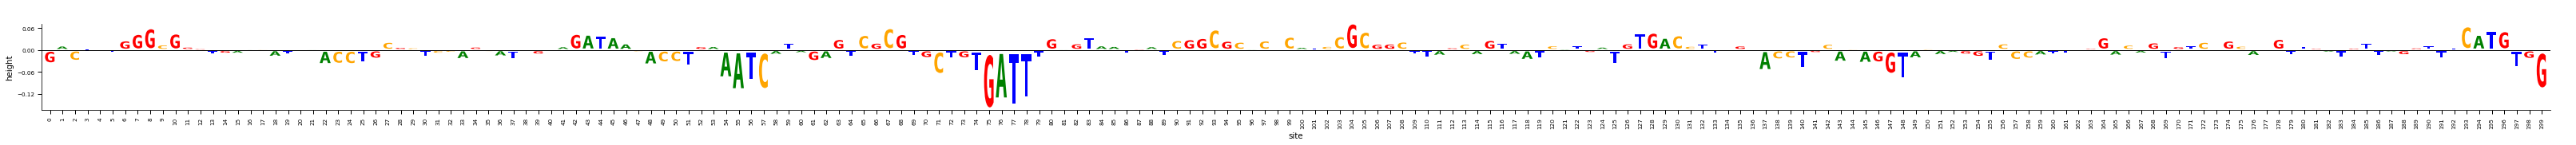

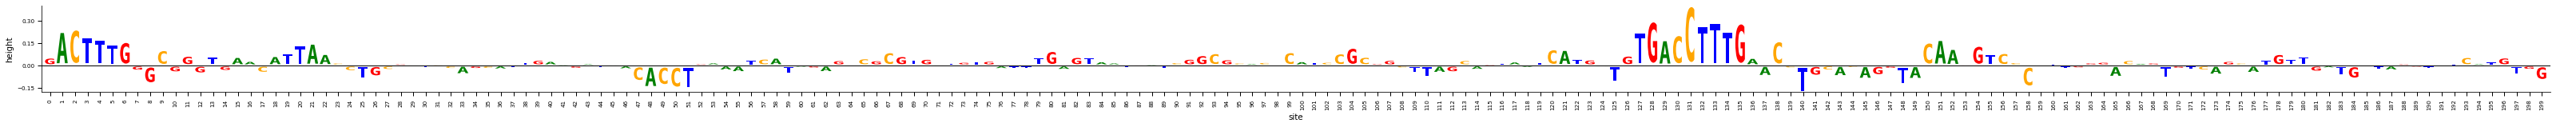

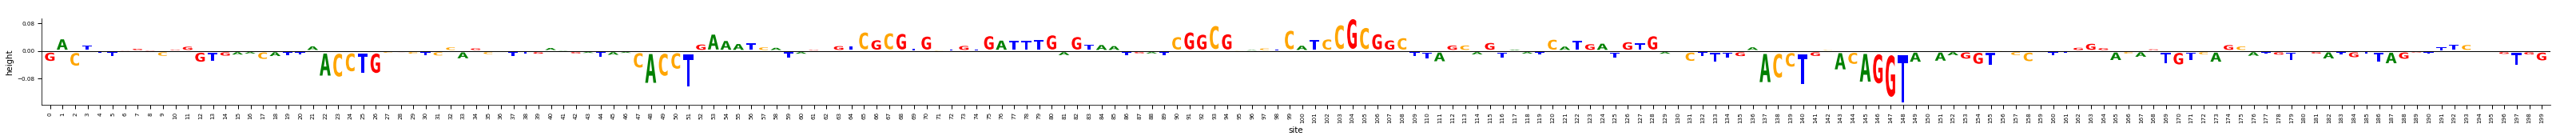


------------------------------ Sequence 3 ------------------------------



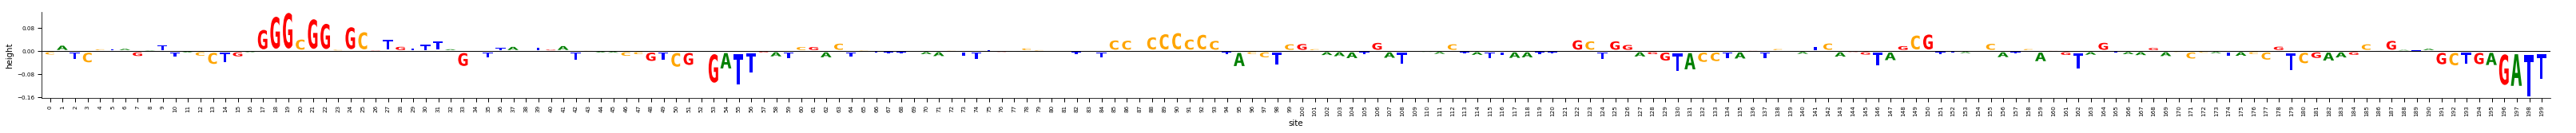

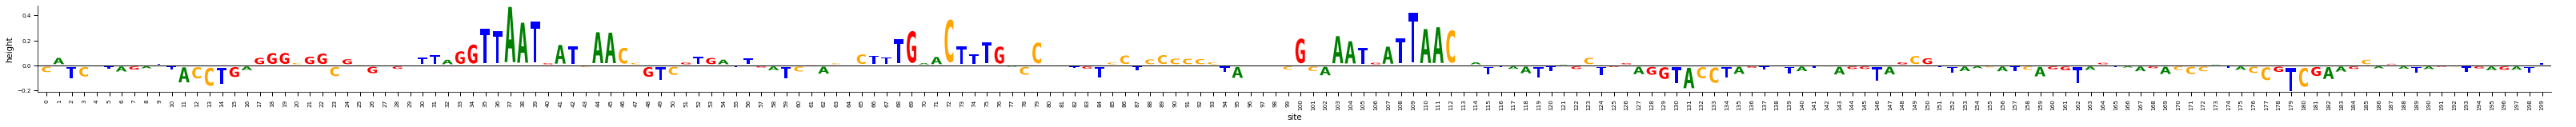

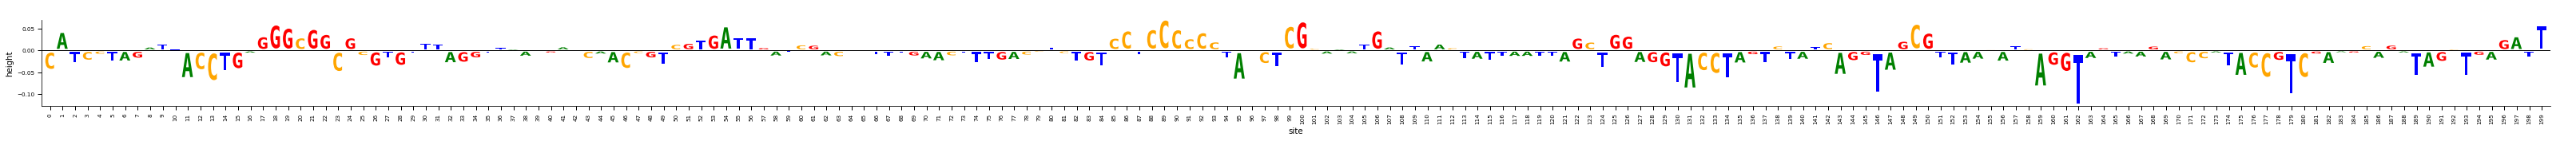


------------------------------ Sequence 4 ------------------------------



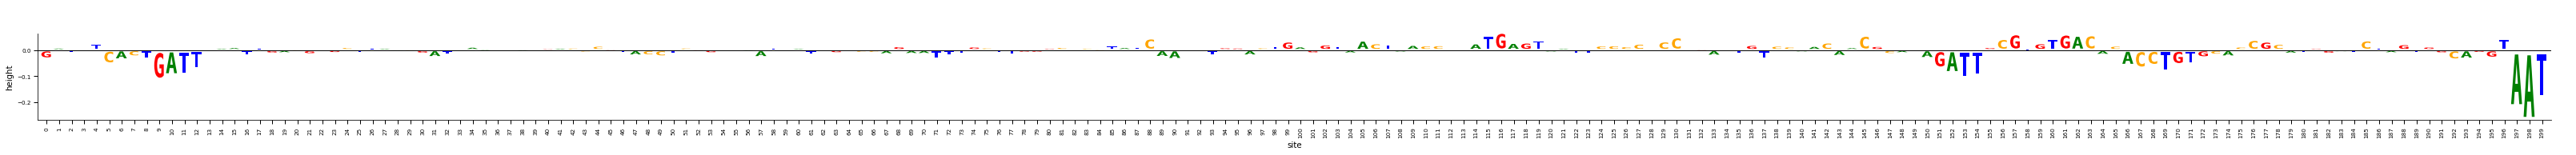

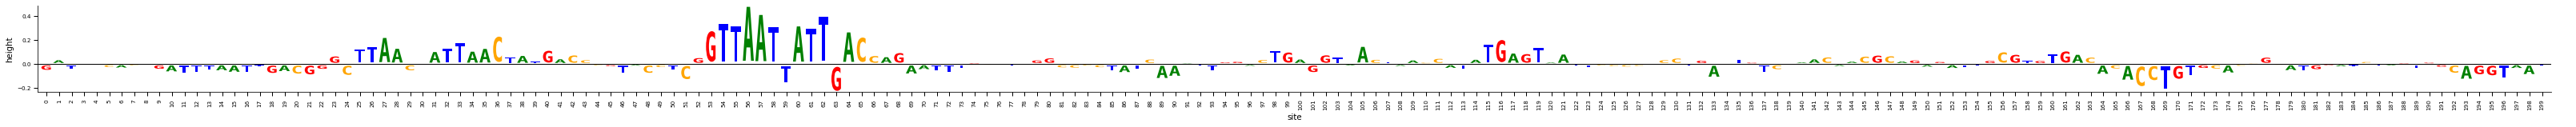

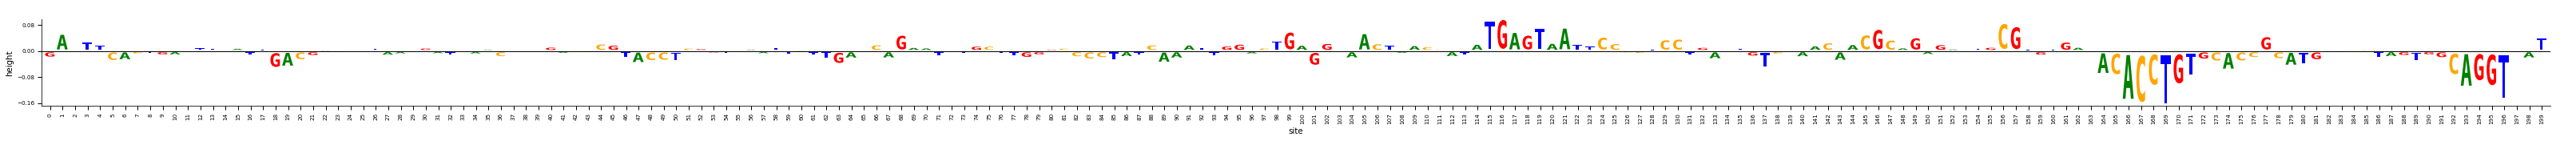


------------------------------ Sequence 5 ------------------------------



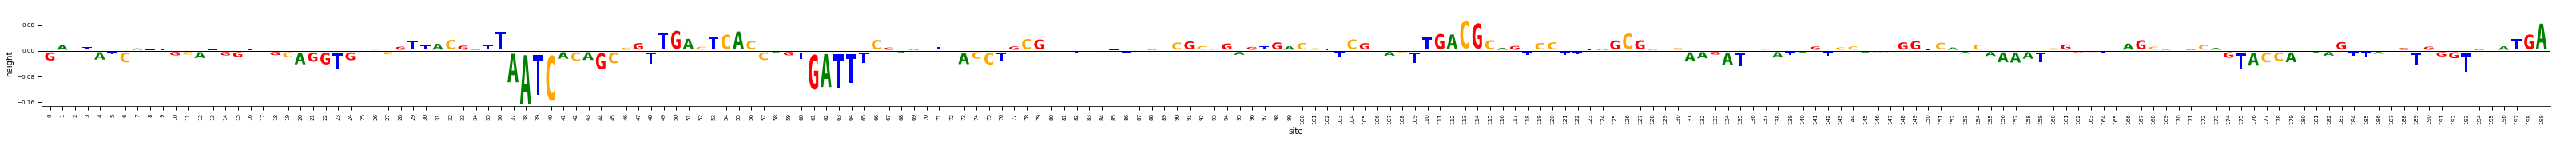

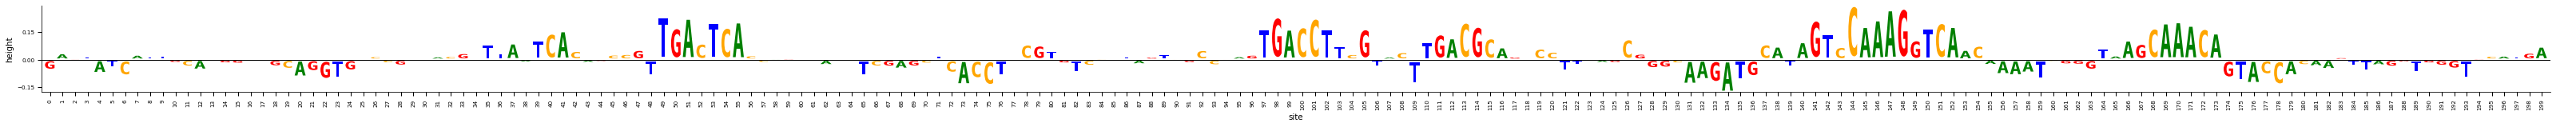

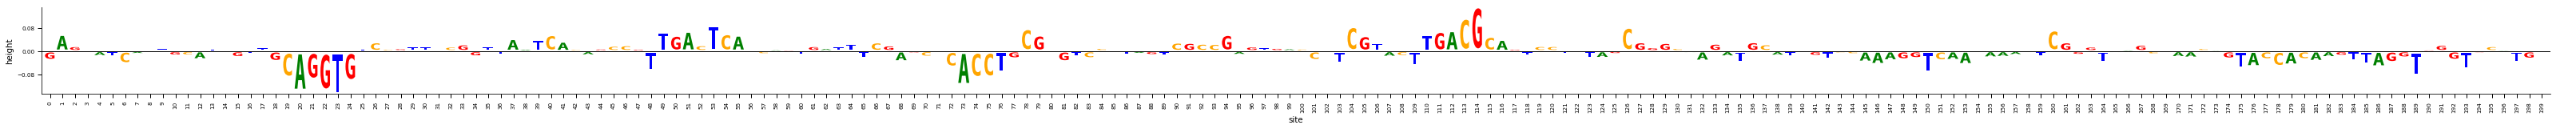

In [14]:
for i in range(batch.shape[0]):
    print('')
    print(f'------------------------------ Sequence {i+1} ------------------------------')
    print('')
#     matrix = batch[i, ...].detach()
#     y_max = matrix.max()
#     fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=0.65, widthscale=0.8,
#                       axisfontscale=0.6, heightscale=0.8)
#     plt.show()
    for j in range(3):
        matrix = all_salient_maps[j][i, ...]
        y_max = matrix.max()
        fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=0.65, widthscale=0.8,
                          axisfontscale=0.6, heightscale=0.8)
        plt.show()

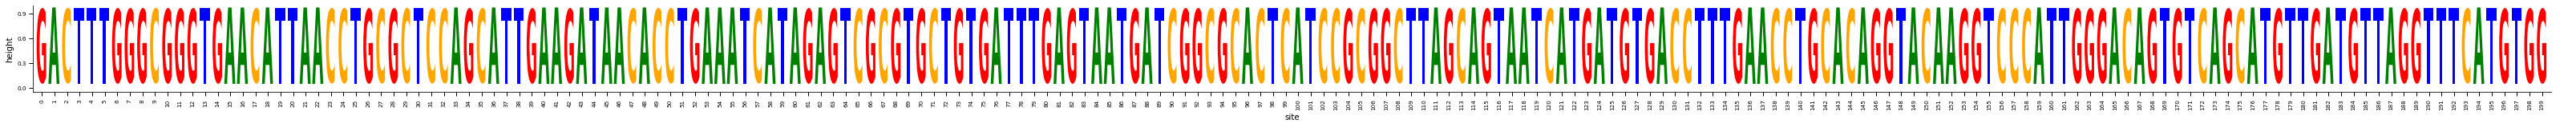

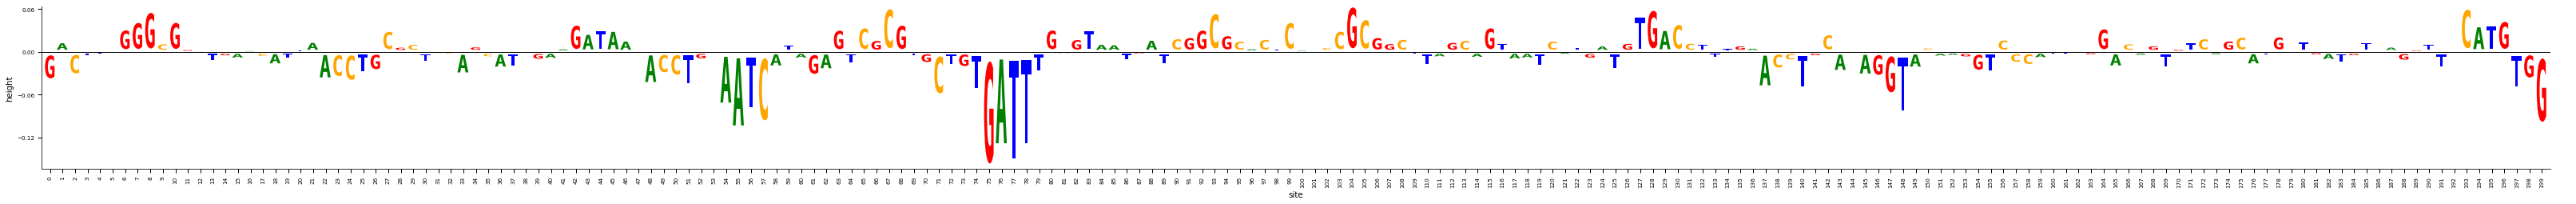

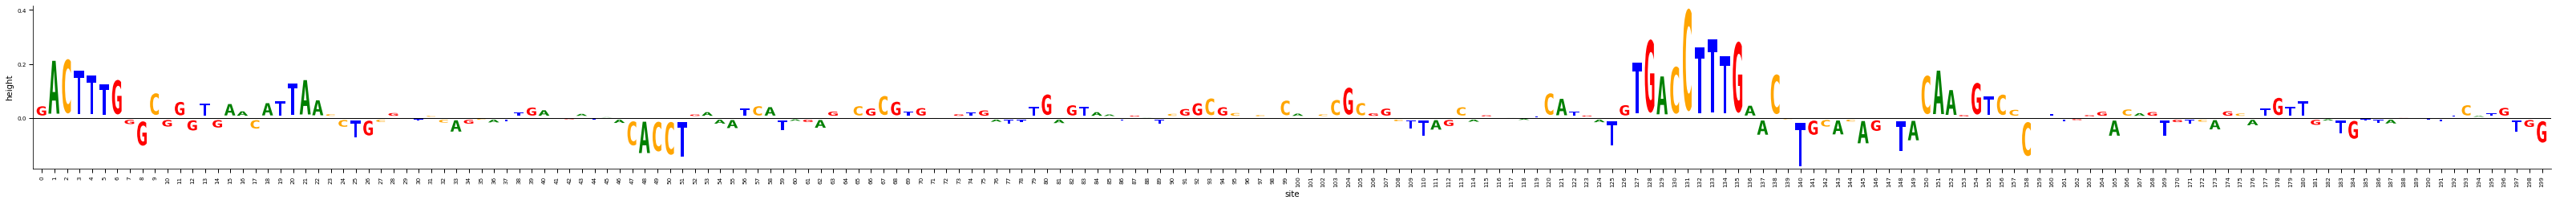

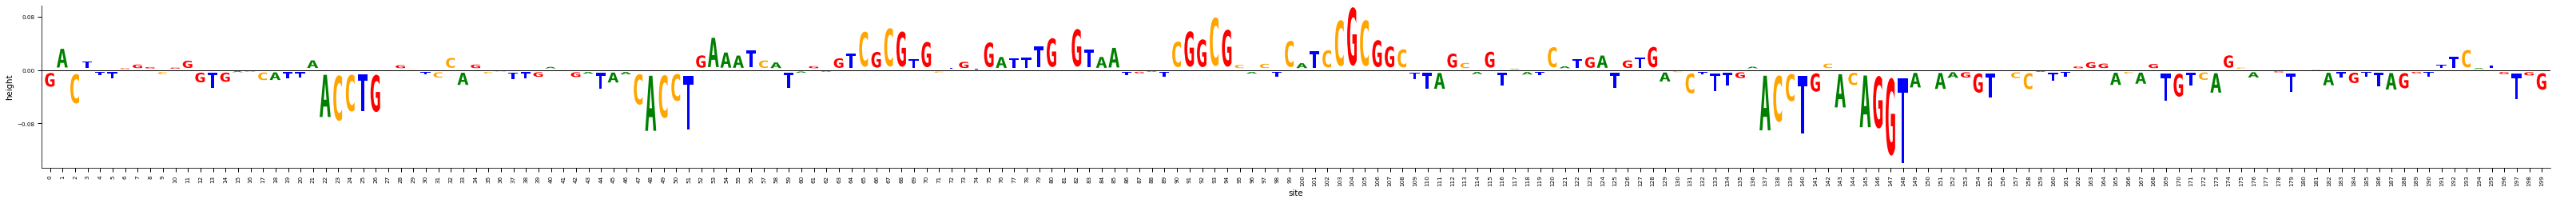

In [10]:
i = 1
matrix = batch[i, ...].detach()
y_max = matrix.max()
fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=0.65, widthscale=0.8,
                  axisfontscale=0.6, heightscale=0.8)
plt.savefig('enhancer_logo.png', transparent=True)
plt.show()
#for j in range(3):

matrix = all_salient_maps[0][i, ...]
y_max = matrix.max()
fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=0.65, widthscale=0.8,
                  axisfontscale=0.6, heightscale=1.5)
# plt.savefig('enhancer_k562.png', transparent=True)
plt.show()

matrix = all_salient_maps[1][i, ...]
y_max = matrix.max()
fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=0.65, widthscale=0.8,
                  axisfontscale=0.6, heightscale=1.5)
# plt.savefig('enhancer_hepg2.png', transparent=True)
plt.show()

matrix = all_salient_maps[2][i, ...]
y_max = matrix.max()
fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=0.65, widthscale=0.8,
                  axisfontscale=0.6, heightscale=1.5)
# plt.savefig('enhancer_sknsh.png', transparent=True)
plt.show()

In [13]:
all_predictions

[tensor([-1.1065, -0.8407, -0.5497, -0.7602, -0.8771], device='cuda:0',
        grad_fn=<SelectBackward>),
 tensor([3.4815, 3.1865, 5.4825, 3.8984, 3.4253], device='cuda:0',
        grad_fn=<SelectBackward>),
 tensor([-1.1016, -0.6706, -0.7039, -0.7909, -0.8406], device='cuda:0',
        grad_fn=<SelectBackward>)]